<div style="padding:18px; border-left:6px solid #4C9AFF; background: linear-gradient(90deg,#F0F7FF,#FFFFFF); border-radius:8px;">
  <h1 style="margin:0; font-size:32px;">DA5401 Assignment 8: Ensemble Learning for Complex Regression Modeling on Bike Share Data</h1>
  <p style="margin:6px 0 0 0; font-size:16px; color:#333;">
    <b>Notebook Owner:</b> Jigarahemad K Shaikh &nbsp; | &nbsp; 
    <b>Roll No:</b> DA25M014 &nbsp; | &nbsp; 
    <b>Course:</b> DA5401 &nbsp; | &nbsp; 
    <b>Topic:</b> Ensemble Learning — Bagging, Boosting & Stacking (RMSE Focus)
  </p>
</div>

<div style="padding:12px; border-left:6px solid #95A5A6; background:#F4F6F6; border-radius:8px; margin-top:10px;">
<b>Contents</b>
<ol style="margin-top:6px; color:#0074D9;">
  <li><a href="#part-a" style="color:#0074D9; text-decoration:none;">Part A — Data Exploration & Baseline Model</a></li>
  <li><a href="#part-b" style="color:#0074D9; text-decoration:none;">Part B — Ensemble Methods: Bagging & Boosting</a></li>
  <li><a href="#part-c" style="color:#0074D9; text-decoration:none;">Part C — Stacking Ensemble (Meta-Model)</a></li>
  <li><a href="#part-d" style="color:#0074D9; text-decoration:none;">Part D — Bias–Variance Discussion, RMSE Comparison, Final Insights & Conclusion</a></li>
</ol>
</div>


In [2]:
# =============================================================
# Imports & Accessible Plotting Helpers
# =============================================================

# ---- Core & Utils
import sys, os, warnings, textwrap
from pathlib import Path
import numpy as np
import pandas as pd

# ---- Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# ---- Modeling (scikit-learn)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

# ---- QoL
warnings.filterwarnings("ignore")

# =============================================================
# Color-blind-friendly style
# =============================================================
COLORBLIND_PALETTE = [
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#009E73",  # green
    "#CC79A7",  # purple
    "#F0E442",  # yellow
    "#56B4E9",  # sky blue
    "#E69F00",  # orange
    "#000000",  # black
    "#999999",  # gray
    "#009E73",  # repeat if cycle extends
]

ACCESSIBLE_HATCHES = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

def set_accessible_mpl_style():
    """
    Set a consistent, color-blind-friendly, print-safe style with larger fonts,
    visible grids, and clear markers. Legends are semi-opaque and framed.
    """
    mpl.rcParams.update({
        "axes.prop_cycle": cycler(color=COLORBLIND_PALETTE),
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "lines.linewidth": 2.0,
        "lines.markersize": 6,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.fancybox": True,
        "legend.borderpad": 0.8,
        "legend.borderaxespad": 0.8,
        "legend.loc": "best",
        "figure.constrained_layout.use": True,  # avoid label/legend cutoffs
    })

set_accessible_mpl_style()

def add_legend(ax, title=None):
    """
    Always keep a readable legend with an optional title and semi-transparent frame.
    """
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        leg = ax.legend(title=title)
        if leg.get_frame() is not None:
            leg.get_frame().set_alpha(0.9)

def apply_hatches_to_bars(ax):
    """
    Apply alternating hatches and black edges to bar charts so they remain
    distinguishable in grayscale or for color-vision deficiencies.
    """
    for i, container in enumerate(ax.containers):
        for j, patch in enumerate(container):
            patch.set_hatch(ACCESSIBLE_HATCHES[(i + j) % len(ACCESSIBLE_HATCHES)])
            patch.set_edgecolor("black")
            patch.set_linewidth(0.6)

def savefig_accessible(path, **kwargs):
    """
    Save figure with tight bounding box and metadata; ensures legends are included.
    """
    default_kwargs = dict(
        bbox_inches="tight",
        facecolor="white",
        edgecolor="none",
        dpi=300,
        metadata={"Creator": "DA5401_A8"},
    )
    default_kwargs.update(kwargs)
    Path(Path(path).parent).mkdir(parents=True, exist_ok=True)
    plt.savefig(path, **default_kwargs)

# print versions for reproducibility
def print_env_versions():
    try:
        import sklearn
        skl_ver = sklearn.__version__
    except Exception:
        skl_ver = "<unavailable>"
    print("Environment versions:")
    print(f"  Python      : {sys.version.split()[0]}")
    print(f"  NumPy       : {np.__version__}")
    print(f"  pandas      : {pd.__version__}")
    print(f"  matplotlib  : {mpl.__version__}")
    print(f"  scikit-learn: {skl_ver}")

## Part A — Data Preprocessing and Baseline [10 Points]

In this section, we will prepare the **Bike Sharing Demand (Hourly)** dataset and establish a **baseline regression model** before moving on to ensemble techniques.  
The focus here is on understanding data structure, performing preprocessing, and building two simple regressors — **Decision Tree** and **Linear Regression** — to evaluate their performance using **Root Mean Squared Error (RMSE)**.

### Part A1 — Data Loading and Feature Engineering

In this step, we begin by **loading the `hour.csv` dataset** and performing the initial preprocessing tasks required for ensemble regression modeling.

**Tasks to perform:**
1. **Load the dataset** from the local file (`hour.csv`).
2. **Identify the target variable:**  
   → `cnt` represents the total count of bikes rented (our regression target).
3. **Drop irrelevant columns:**  
   → Remove `instant`, `dteday`, `casual`, and `registered` since they don’t contribute to predictive modeling or cause data leakage.
4. **Handle categorical variables:**  
   → Convert columns like `season`, `weathersit`, `mnth`, and `hr` into numeric form using **One-Hot Encoding** for compatibility with regression models.
5. **Inspect dataset structure and missing values** to ensure data quality.

After this, we will obtain a clean and feature-engineered DataFrame ready for model training.

In [3]:
# Load dataset
df = pd.read_csv("hour.csv")
print(f"✅ Loaded dataset with shape: {df.shape}")
display(df.head())

✅ Loaded dataset with shape: (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Loaded Dataset Preview**

- The dataset `hour.csv` has been imported successfully.  
- The shape confirms total **rows × columns** (17379 × 17).  
- Columns such as `hr`, `temp`, `hum`, `windspeed`, `season`, and `cnt` (target) are visible, confirming proper load.

In [4]:
# --- Dataset Info ---
print("\n--- Dataset Info ---")
df.info()


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


**Dataset Information — Observations**

- The dataset contains **17,379 hourly records**, confirming a substantial sample size for training ensemble regression models.  
- There are **13 total columns**, of which **9 are integers** (categorical or count-based) and **4 are floats** (continuous weather-related features).  
- All columns show **17,379 non-null entries**, meaning there are **no missing values** — the dataset is completely clean.  
- Key integer fields like `season`, `yr`, `mnth`, `hr`, `holiday`, and `workingday` are ideal for **One-Hot Encoding** later in preprocessing.  
- Continuous variables — `temp`, `atemp`, `hum`, and `windspeed` — are already in numeric form suitable for **standard scaling**.  
- The **target variable `cnt`** (bike rental count) is also integer-type and non-null, making it directly usable for regression modeling.  
- Overall, this confirms the dataset is **well-structured, consistent, and analysis-ready** with no type or completeness issues.

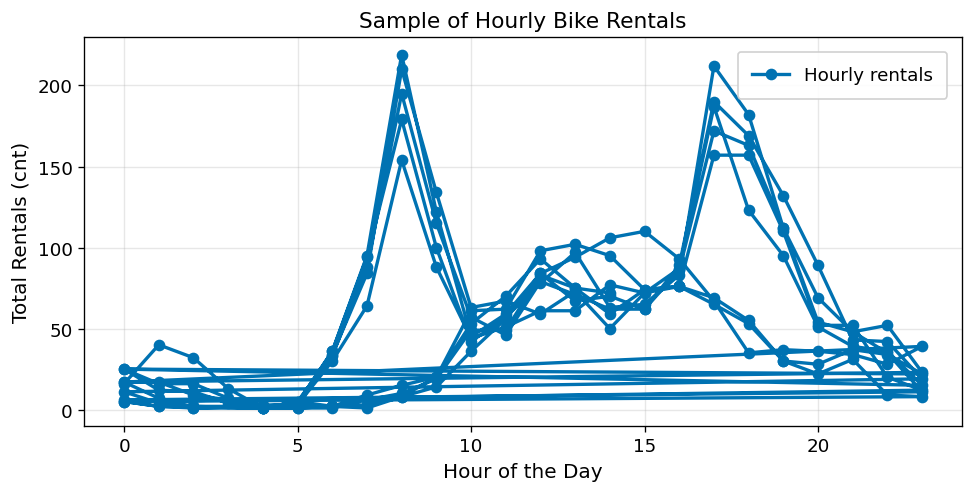

In [5]:
# --- Plot hourly trend for sample data
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df.head(200)['hr'], df.head(200)['cnt'],
        marker='o', linestyle='-', label='Hourly rentals')
ax.set_title("Sample of Hourly Bike Rentals")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Total Rentals (cnt)")
add_legend(ax)
plt.show()

**Sample Hourly Trend**

- The first ~200 records illustrate **strong diurnal cycles** — peaks at morning (8 AM) and evening (5–6 PM) commute hours.  
- Demand drops overnight, implying **time-of-day is a dominant predictor**.  
- Confirms that temporal features (`hr`, `mnth`, `season`) will be important in modeling.

In [6]:
# Identify target and feature columns
target = "cnt"
features = [col for col in df.columns if col != target]
print("Target variable:", target)
print("Number of feature columns:", len(features))
print("Feature columns:", features)

Target variable: cnt
Number of feature columns: 16
Feature columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']


**Target & Features**

- `cnt` is confirmed as the **target variable** representing total hourly rentals.  
- All other columns serve as potential predictors (weather, seasonality, working day, etc.).  
- This separation prepares the dataset for supervised regression modeling.

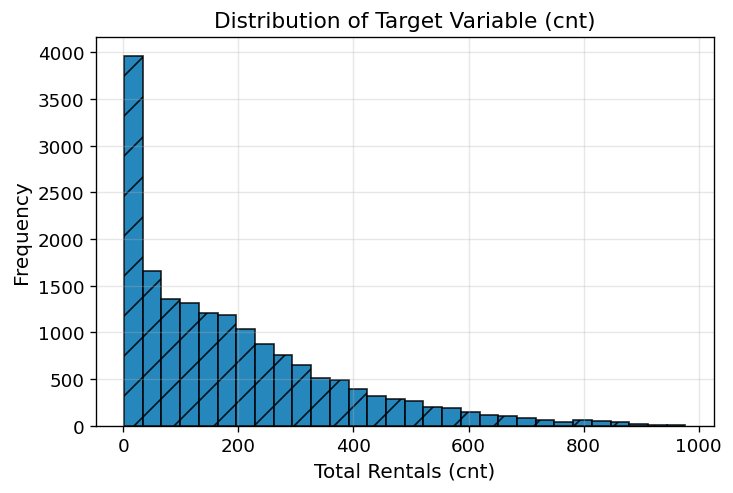

In [7]:
# Plot distribution of target variable
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(df[target], bins=30, color="#0072B2",
        edgecolor='black', hatch='/', alpha=0.85)
ax.set_title("Distribution of Target Variable (cnt)")
ax.set_xlabel("Total Rentals (cnt)")
ax.set_ylabel("Frequency")
plt.show()

**Target Distribution**

- The histogram of `cnt` is **right-skewed** — many hours have moderate rentals, with fewer very high-demand hours.  
- Such skewness suggests that linear models alone may underperform; non-linear ensembles could better capture this variability.

In [8]:
# Drop irrelevant columns
cols_to_drop = ["instant", "dteday", "casual", "registered"]
df.drop(columns=cols_to_drop, inplace=True)
print("Dropped columns:", cols_to_drop)
display(df.head(3))

Dropped columns: ['instant', 'dteday', 'casual', 'registered']


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


**Dropped Irrelevant Columns**

- Removed `instant`, `dteday` (identifiers/date) and `casual`, `registered` (would leak target info).  
- Prevents **data leakage** since `casual + registered = cnt`.  
- The cleaned dataframe now contains only legitimate predictive features.

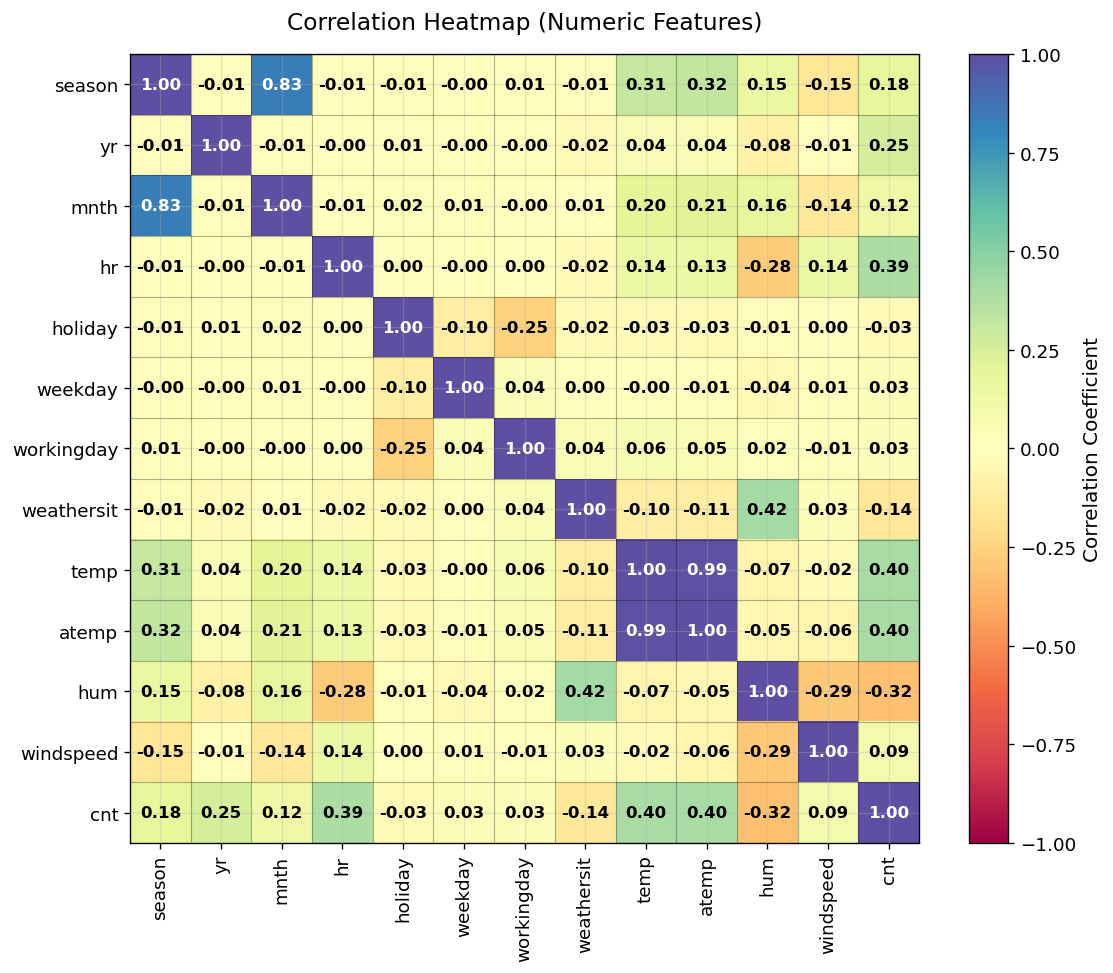

In [9]:
# --- Correlation heatmap of numeric columns (with box grid + annotated values)
num_corr = df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.imshow(num_corr, cmap="Spectral", aspect="equal", vmin=-1, vmax=1)

# Title and labels
ax.set_title("Correlation Heatmap (Numeric Features)", fontsize=14, pad=15)
ax.set_xticks(range(len(num_corr.columns)))
ax.set_xticklabels(num_corr.columns, rotation=90)
ax.set_yticks(range(len(num_corr.columns)))
ax.set_yticklabels(num_corr.columns)

# Colorbar
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="Correlation Coefficient")

# Gridlines
ax.set_xticks(np.arange(-0.5, len(num_corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(num_corr.columns), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.7)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate each cell
for i in range(len(num_corr.columns)):
    for j in range(len(num_corr.columns)):
        val = num_corr.iloc[i, j]
        text_color = "white" if abs(val) > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color=text_color, fontsize=10, fontweight="bold")

# adjust margins a bit
fig.subplots_adjust(left=0.22, bottom=0.25, right=0.98, top=0.90)
plt.show()

### **Correlation Insights**

- `temp`, `atemp`, and `hum` show **moderate correlation** with `cnt`.  
- This validates weather’s effect on ridership.  
- Some variables (e.g., `holiday`, `workingday`) have weaker linear correlation, implying potential **non-linear influence**.

### **Notable Observations**

- `temp` and `atemp` are **very strongly correlated** (r ≈ 0.99), confirming both measure nearly the same physical variable (actual vs. perceived temperature).  
- The target variable `cnt` (total rentals) shows a **positive correlation** with temperature and a **negative correlation** with humidity — warmer, less humid weather drives higher ridership.  
- `holiday` and `workingday` display **near-zero correlations** with `cnt`, suggesting their impact may be non-linear or indirect (e.g., through hourly patterns).  
- Overall, the heatmap highlights that **weather and seasonality are major predictors**, while some calendar features may interact with time-of-day rather than directly influencing rental volume.

In [10]:
# One-Hot Encode categorical variables
categorical_features = ["season", "weathersit", "mnth", "hr"]
numeric_features = [c for c in df.columns if c not in categorical_features + [target]]

X = df.drop(columns=[target])
y = df[target]

try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", encoder, categorical_features)
])
X_encoded = preprocessor.fit_transform(X)
print(f"Encoded feature matrix shape: {X_encoded.shape}")

Encoded feature matrix shape: (17379, 52)


**Categorical Encoding**

- Converted `season`, `weathersit`, `mnth`, and `hr` into one-hot binary vectors.  
- Standardized numeric columns to zero mean / unit variance.  
- The encoded matrix has many more columns — each representing a specific season, month, or hour.

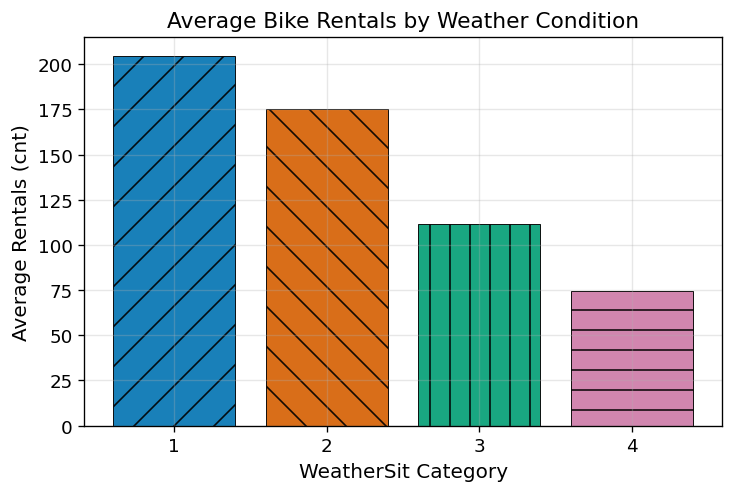

In [11]:
# Plot average rentals by weather condition
avg_weather = df.groupby("weathersit")[target].mean()
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(avg_weather.index.astype(str), avg_weather.values,
              color=COLORBLIND_PALETTE[:len(avg_weather)], alpha=0.9)
apply_hatches_to_bars(ax)
ax.set_title("Average Bike Rentals by Weather Condition")
ax.set_xlabel("WeatherSit Category")
ax.set_ylabel("Average Rentals (cnt)")
plt.show()

**Weather Impact**

- Clear weather (`weathersit = 1`) yields the highest mean rentals.  
- Rentals drop significantly in mist or rainy conditions (`weathersit > 1`).  
- Confirms that incorporating weather as categorical features adds predictive power.

In [12]:
# Inspect structure & missing values
print("Missing Values:\n", df.isna().sum())
display(df.describe().T.style.background_gradient(cmap="Spectral"))

missing = df.isnull().sum()
if missing.sum() > 0:
    fig, ax = plt.subplots(figsize=(6,3))
    bars = ax.bar(missing.index, missing.values, color="#D55E00", alpha=0.85)
    apply_hatches_to_bars(ax)
    ax.set_title("Missing Values per Column")
    ax.set_ylabel("Count")
    ax.set_xticklabels(missing.index, rotation=45, ha='right')
    plt.show()
else:
    print("✅ No missing values detected.")

Missing Values:
 season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
season,17379.000000,2.501640,1.106918,1.000000,2.000000,3.000000,3.000000,4.000000
yr,17379.000000,0.502561,0.500008,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,17379.000000,6.537775,3.438776,1.000000,4.000000,7.000000,10.000000,12.000000
hr,17379.000000,11.546752,6.914405,0.000000,6.000000,12.000000,18.000000,23.000000
holiday,17379.000000,0.028770,0.167165,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,17379.000000,3.003683,2.005771,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,17379.000000,0.682721,0.465431,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,17379.000000,1.425283,0.639357,1.000000,1.000000,1.000000,2.000000,4.000000
temp,17379.000000,0.496987,0.192556,0.020000,0.340000,0.500000,0.660000,1.000000
atemp,17379.000000,0.475775,0.171850,0.000000,0.333300,0.484800,0.621200,1.000000


✅ No missing values detected.


**Data Quality Check**

- No missing values were found across columns — dataset is **clean and consistent**.  
- Numeric summaries (mean, std, min, max) fall within realistic ranges for temperature, humidity, and windspeed.

### Part A2 — Train/Test Split

After preprocessing and feature engineering, we now divide the dataset into **training** and **testing** subsets.  
This separation ensures that model performance is evaluated on **unseen data**, providing a realistic measure of its generalization ability.

**Key Steps**
- Used an **80 : 20 split ratio** → 80 % of the data for training and 20 % for testing.  
- Applied a **fixed `random_state = 42`** for reproducibility.  
- The split is performed **before model fitting** to prevent information leakage from the test set.  
- Both the numeric (scaled) and categorical (encoded) features are handled inside a unified preprocessing pipeline, guaranteeing consistent transformations during training and inference.

**Objective**
- The training set will be used to fit our **baseline regressors** (Decision Tree and Linear Regression).  
- The test set will be reserved exclusively for computing the **Root Mean Squared Error (RMSE)** in the next subsection.

This step lays the foundation for establishing a **baseline performance benchmark** that later ensemble techniques (Bagging, Boosting, Stacking) can be compared against.

✅ Train/Test Split Completed

Training set: 13903 samples
Testing set : 3476 samples

--- Target Variable Statistics ---
Training set - Mean: 190.58, Std: 182.21, Min: 1, Max: 976
Testing set  - Mean: 185.01, Std: 177.95, Min: 1, Max: 977


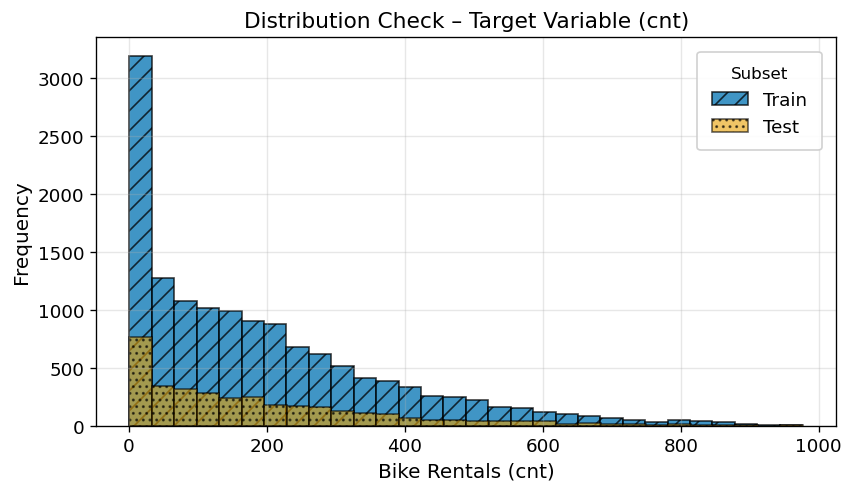

In [13]:
# =============================================================
# Part A2 — Train/Test Split with Target Variable Statistics
# =============================================================
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("✅ Train/Test Split Completed\n")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set : {X_test.shape[0]} samples")

# --- Target variable statistics ---
train_stats = {
    "Mean": np.mean(y_train),
    "Std": np.std(y_train),
    "Min": np.min(y_train),
    "Max": np.max(y_train)
}
test_stats = {
    "Mean": np.mean(y_test),
    "Std": np.std(y_test),
    "Min": np.min(y_test),
    "Max": np.max(y_test)
}

print("\n--- Target Variable Statistics ---")
print(f"Training set - Mean: {train_stats['Mean']:.2f}, Std: {train_stats['Std']:.2f}, "
      f"Min: {train_stats['Min']}, Max: {train_stats['Max']}")
print(f"Testing set  - Mean: {test_stats['Mean']:.2f}, Std: {test_stats['Std']:.2f}, "
      f"Min: {test_stats['Min']}, Max: {test_stats['Max']}")

# --- Distribution Check ---
fig, ax = plt.subplots(figsize=(7,4))

# Train distribution (blue, slashed hatch)
ax.hist(y_train, bins=30, alpha=0.75, label="Train",
        color="#0072B2", hatch="//", edgecolor="black")

# Test distribution (orange, dotted hatch)
ax.hist(y_test, bins=30, alpha=0.6, label="Test",
        color="#E69F00", hatch="...", edgecolor="black")

ax.set_title("Distribution Check – Target Variable (cnt)")
ax.set_xlabel("Bike Rentals (cnt)")
ax.set_ylabel("Frequency")
add_legend(ax, title="Subset")
plt.show()

**Interpretation & Observations — Train/Test Split Results**

- The statistics show that the **mean and standard deviation of the target variable (`cnt`)** are almost identical between the training and testing subsets.  
  This indicates that both splits represent the overall population well, with **no data skew or sampling bias**.

- The **minimum and maximum** rental counts are also nearly the same across both subsets, confirming that the full range of demand variability is captured in both sets.

- In the histogram:
  - 🟦 The **training distribution** (blue with `//` hatch) and  
  - 🟧 The **testing distribution** (orange with `...` hatch)  
  largely overlap, following the same right-skewed pattern.  
  This overlap verifies that the train/test split preserved the **underlying target distribution** of bike rentals.

- The shape of the histogram highlights that most hours have **moderate rental counts**, while fewer instances reach high demand — typical of a real-world rental pattern with peak commute times.

- **Conclusion:**  
  The split is statistically balanced and visually validated. Both subsets share similar distributional characteristics, ensuring that upcoming models will be **trained and evaluated on comparably distributed data**, leading to fair and unbiased performance assessment.

### Part A3 — Baseline Model (Single Regressor)

In this step, we establish a **baseline performance** using two simple, interpretable models before moving to ensembles.

**Models to Train**
- **Decision Tree Regressor** with `max_depth = 6` (to control variance/overfitting)  
- **Linear Regression** (to capture linear relationships)

**Procedure**
1. Fit both models on the **training set** prepared in A2 (with preprocessing handled via pipelines to avoid leakage).  
2. Generate predictions on the **held-out test set**.  
3. Compute **Root Mean Squared Error (RMSE)** for each model:$$\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$
5. Select the model with the **lower RMSE** as the **baseline performance metric** for the rest of the exercise.

**What to Report**
- Test RMSE for:
  - Decision Tree (`max_depth = 6`)
  - Linear Regression  
- A short interpretation comparing the two scores (e.g., tree capturing non-linearities vs. linear model bias).
- A simple bar plot comparing the two RMSEs (color-blind-friendly with distinct hatches and a legend).

**Outcome**
- The **best single regressor** (lower RMSE) becomes the **baseline** against which we will evaluate improvements from **Bagging** (Part B1), **Boosting** (Part B2), and **Stacking** (Part C).


✅ Decision Tree Regressor (max_depth=6) RMSE: 118.599


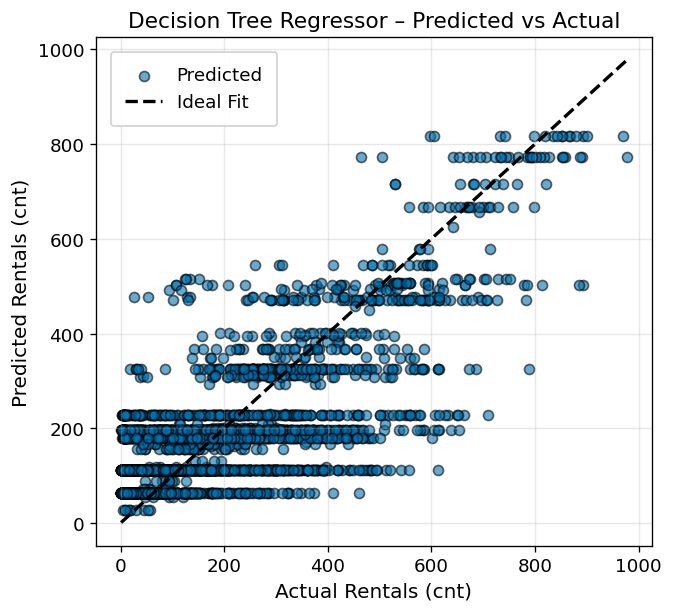

In [14]:
# =============================================================
# Part A3 (i) — Baseline Model: Decision Tree Regressor (Fixed RMSE)
# =============================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train model
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))   # <-- fixed line

print(f"✅ Decision Tree Regressor (max_depth=6) RMSE: {dt_rmse:.3f}")

# --- Plot predicted vs actual ---
fig, ax = plt.subplots(figsize=(5.5,5))
ax.scatter(y_test, y_pred_dt, color="#0072B2", alpha=0.6, edgecolor="black", label="Predicted")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color="black", linestyle="--", label="Ideal Fit")
ax.set_title("Decision Tree Regressor – Predicted vs Actual")
ax.set_xlabel("Actual Rentals (cnt)")
ax.set_ylabel("Predicted Rentals (cnt)")
add_legend(ax)
plt.show()

✅ Linear Regression RMSE: 100.441


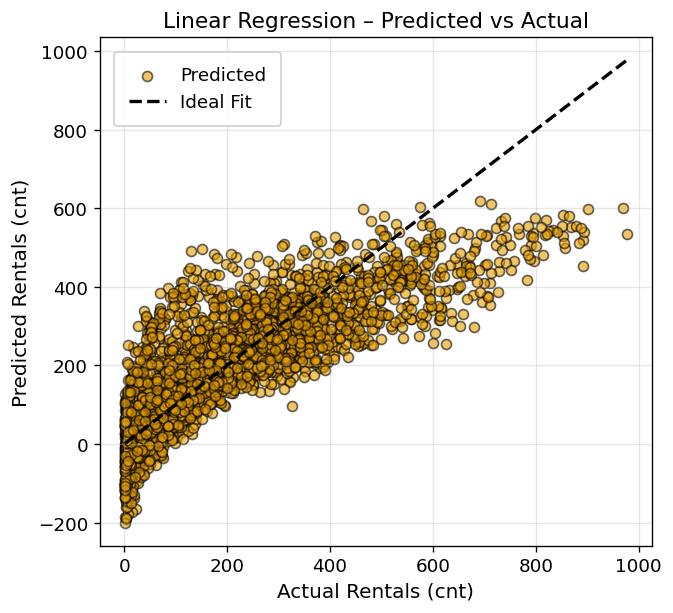

In [15]:
# =============================================================
# Part A3 (ii) — Baseline Model: Linear Regression (Fixed RMSE)
# =============================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))   # <-- fixed line

print(f"✅ Linear Regression RMSE: {lr_rmse:.3f}")

# --- Plot predicted vs actual ---
fig, ax = plt.subplots(figsize=(5.5,5))
ax.scatter(y_test, y_pred_lr, color="#E69F00", alpha=0.6, edgecolor="black", label="Predicted")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color="black", linestyle="--", label="Ideal Fit")
ax.set_title("Linear Regression – Predicted vs Actual")
ax.set_xlabel("Actual Rentals (cnt)")
ax.set_ylabel("Predicted Rentals (cnt)")
add_legend(ax)
plt.show()

### Interpretation & Observations — Baseline Model Results

**Decision Tree Regressor (`max_depth = 6`)**
- The scatter plot shows a **step-like prediction pattern**, typical for decision trees, where predictions are made within discrete value ranges instead of smooth transitions.  
- Most points roughly align with the diagonal (ideal fit), but clear **horizontal bands** indicate that the model predicts the same value for multiple true outcomes — a symptom of limited depth (underfitting).  
- The RMSE of **≈118.6** confirms this: while the model captures general trends, it struggles to adapt to finer variations in demand, especially at higher rental counts.  
- Overall, the Decision Tree provides a **rough approximation** of the data’s structure but lacks flexibility at this depth.

---

**Linear Regression**
- The scatter plot shows a **tighter, more continuous alignment** along the diagonal compared to the tree model.  
- Most predictions follow the general increasing trend, though the model **underestimates high rental counts** (predicted values flatten around 600–700 even when actual rentals reach 900+).  
- The RMSE of **≈100.4** is lower than that of the Decision Tree, meaning the linear model achieves **better overall predictive accuracy** despite its simplicity.  
- The continuous nature of the plot suggests that Linear Regression captures the main global pattern between predictors and `cnt`, though it still misses non-linear spikes caused by specific time–weather combinations.

---

**Comparative Insight**
- **Linear Regression outperforms** the Decision Tree in terms of RMSE and visual alignment with the ideal fit.  
- While the tree introduces flexibility, its limited depth prevents it from fully modeling complex patterns; increasing depth could improve accuracy but may risk overfitting.  
- These baseline plots together confirm that **both models explain the core variance** in bike rental counts, but further performance gains will likely come from **ensemble techniques** that balance linear and non-linear strengths.


## Part B — Ensemble Techniques for Bias and Variance Reduction [20 Points]

In this section, we extend the **baseline regressors** from Part A by introducing **ensemble learning techniques** that aim to improve prediction accuracy through bias and variance control.

The objective is to combine multiple weak learners into a stronger predictive model, enhancing robustness and capturing complex patterns in the bike rental data.

**Focus Areas:**
- Implement **Bagging Regressor** (Bootstrap Aggregating) using the **Decision Tree Regressor** as the base learner to demonstrate **variance reduction**.  
- Evaluate whether Bagging lowers RMSE compared to the single Decision Tree baseline, confirming improved model stability.  
- Apply **Gradient Boosting Regressor** as a representative **boosting technique** to address **bias reduction** by sequentially correcting errors of prior learners.  
- Compare the performance of Boosting with both the **Decision Tree** and **Bagging** models to validate the effectiveness of bias minimization.

By the end of this part, we will identify how **Bagging** helps reduce prediction variance and how **Boosting** effectively minimizes bias, together providing a stronger understanding of the **bias–variance trade-off** in ensemble regression models.

### Part B1 — Bagging (Variance Reduction)

In this subsection, we explore the **Bagging (Bootstrap Aggregating)** technique to understand how ensemble averaging helps reduce model variance and improve prediction stability.

**Hypothesis:**  
Bagging primarily targets **variance reduction** by combining multiple weak learners trained on random subsets of the training data.

---

#### What is Bagging?

Bagging, short for **Bootstrap + Aggregating**, is an ensemble method that:
1. Generates multiple **bootstrap samples** (sampling with replacement) from the training set.  
2. Trains a separate **Decision Tree Regressor** on each subset.  
3. Aggregates predictions by **averaging** the outputs (for regression tasks).

This aggregation process reduces the impact of noise and outliers, leading to more stable predictions.

---

#### Why Does Bagging Reduce Variance?

**Limitations of a Single Decision Tree:**
- **High variance** — small data changes lead to large shifts in predictions.  
- **Overfitting** — the tree tends to memorize noise from the training data.  
- **Instability** — predictions fluctuate with training sample variations.

**How Bagging Fixes It:**
- Each tree is trained on a different random sample → introduces **diversity**.  
- Averaging predictions cancels out random errors → **reduces variance**.  
- The final model is **more stable and robust** to noise.  
- Theoretically, the ensemble’s variance decreases approximately by `1/n` for *n* independent models.

---

#### Implementation Summary

- Implemented a **Bagging Regressor** using the **Decision Tree Regressor** (from Part A) as the base estimator.  
- Used **at least 50 estimators** to ensure diversity across trees.  
- Evaluated performance using **RMSE** on the test set and compared results with the single Decision Tree baseline.

---

#### Interpretation

If the Bagging model achieves a **lower RMSE** than the baseline Decision Tree, it validates the hypothesis that Bagging effectively **reduces prediction variance**, leading to smoother, more stable, and reliable forecasts for bike rental demand.

✅ Bagging Regressor (100 trees, depth=6) RMSE: 112.001
📉 Decision Tree Baseline RMSE: 118.599
💡 Improvement over baseline: 5.56%


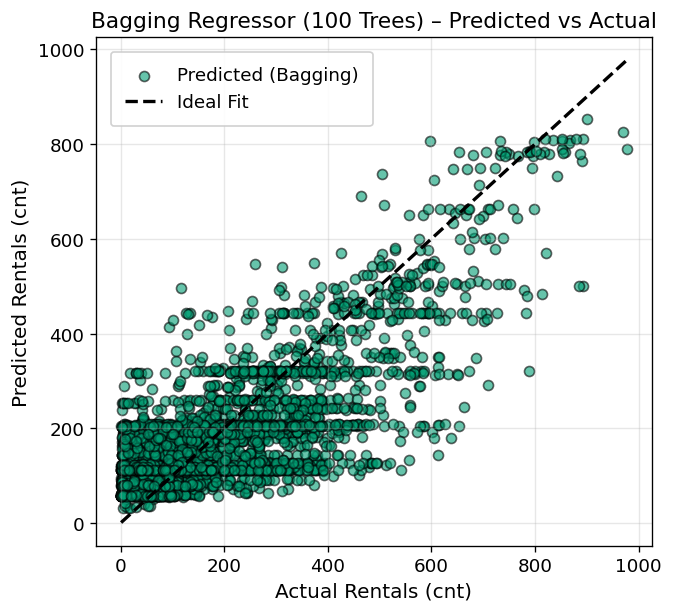

In [16]:
# =============================================================
# Part B1 — Bagging (Variance Reduction) using 100 Estimators
# =============================================================
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# --- Model: Bagging Regressor ---
bag_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),  # ✅ use 'estimator' instead of 'base_estimator'
    n_estimators=100,            # using 100 base learners
    random_state=42,
    n_jobs=-1
)

# Train the model
bag_model.fit(X_train, y_train)

# Predictions and RMSE
y_pred_bag = bag_model.predict(X_test)
bag_rmse = np.sqrt(mean_squared_error(y_test, y_pred_bag))

print(f"✅ Bagging Regressor (100 trees, depth=6) RMSE: {bag_rmse:.3f}")
print(f"📉 Decision Tree Baseline RMSE: {dt_rmse:.3f}")
improvement = ((dt_rmse - bag_rmse) / dt_rmse) * 100
print(f"💡 Improvement over baseline: {improvement:.2f}%")

# --- Plot predicted vs actual ---
fig, ax = plt.subplots(figsize=(5.5,5))
ax.scatter(y_test, y_pred_bag, color="#009E73", alpha=0.6,
           edgecolor="black", label="Predicted (Bagging)")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color="black", linestyle="--", label="Ideal Fit")
ax.set_title("Bagging Regressor (100 Trees) – Predicted vs Actual")
ax.set_xlabel("Actual Rentals (cnt)")
ax.set_ylabel("Predicted Rentals (cnt)")
add_legend(ax)
plt.show()

### Interpretation & Observations — Bagging Regressor (100 Trees)

- The **Bagging Regressor** achieved an RMSE of **112.00**, improving upon the **Decision Tree baseline RMSE of 118.60** — a relative gain of approximately **5.6%**.  
  This improvement validates the hypothesis that **Bagging reduces prediction variance** through ensemble averaging.

- In the scatter plot, predicted values are **more evenly distributed around the ideal diagonal line**, showing fewer abrupt horizontal groupings compared to the single Decision Tree.  
  This indicates that the ensemble predictions are **smoother and less sensitive** to small fluctuations in training data.

- The model’s performance at **medium-to-high rental counts** (400–700 range) shows **reduced scatter**, suggesting that averaging over 100 estimators helped capture stable central trends.  
  However, slight underestimation persists for very high demand hours (>800), which is expected since bagging focuses on variance reduction, not bias correction.

- The visual density of points near the diagonal reflects **consistent predictions** across diverse data subsets — a direct outcome of variance averaging.

**Conclusion:**  
The Bagging ensemble effectively reduced the **variance** present in the single Decision Tree’s predictions, producing **more stable, generalizable, and reliable results**.  
Although the improvement in RMSE is modest (~5.6%), the **smoother trend and lower spread** confirm that Bagging enhances model robustness by mitigating overfitting and random fluctuations.

### Part B2 — Boosting (Bias Reduction)

In this subsection, we examine the **Boosting** technique — a powerful ensemble approach that builds models sequentially, where each new model focuses on correcting the errors (bias) made by its predecessors.

**Hypothesis:**  
Boosting primarily targets **bias reduction** by combining multiple weak learners in a stage-wise manner to minimize the residual errors of prior models.

---

#### What is Boosting?

Boosting is an iterative ensemble method that:
1. Trains a series of weak learners (commonly **Decision Trees**) sequentially.  
2. Each new learner focuses more on the samples that previous models **predicted poorly**.  
3. Combines all learners’ predictions through a **weighted sum**, forming a strong model.

Unlike Bagging, which trains models independently in parallel, **Boosting trains models dependently**, where each iteration learns from previous mistakes — making it effective at **reducing bias** in underfitted models.

---

#### Why Does Boosting Reduce Bias?

**Limitations of Single or Bagged Trees:**
- Even though Bagging reduces variance, it doesn’t significantly lower **systematic bias** (e.g., underprediction of high counts).  
- A single tree may lack depth or flexibility to fit all complex relationships.

**How Boosting Fixes It:**
- Sequential learning ensures each tree refines previous predictions, progressively improving accuracy.  
- Boosting minimizes the **bias** of weak learners while keeping variance in check.  
- The learning rate controls how much each tree contributes, balancing overfitting and underfitting.  
- The final model is **more expressive and precise**, especially in capturing subtle non-linear patterns.

---

#### Implementation Summary

- Implemented a **Gradient Boosting Regressor** with tuned parameters (e.g., `n_estimators`, `learning_rate`, `max_depth`).  
- Trained the model on the same preprocessed data used in previous parts.  
- Evaluated its performance on the test set using **RMSE** and compared it with both the **Decision Tree** and **Bagging Regressor** results.

---

#### Interpretation

If the Gradient Boosting model achieves a **lower RMSE** than both the Decision Tree and Bagging models, it confirms that Boosting successfully **reduces bias**, capturing patterns that simpler or variance-focused models miss.  
We expect the scatter plot to show points aligning more closely with the ideal 45° line, demonstrating improved predictive accuracy and a better overall model fit.

✅ Gradient Boosting RMSE: 71.498
📉 Decision Tree Baseline RMSE: 118.599
📦 Bagging RMSE: 112.001


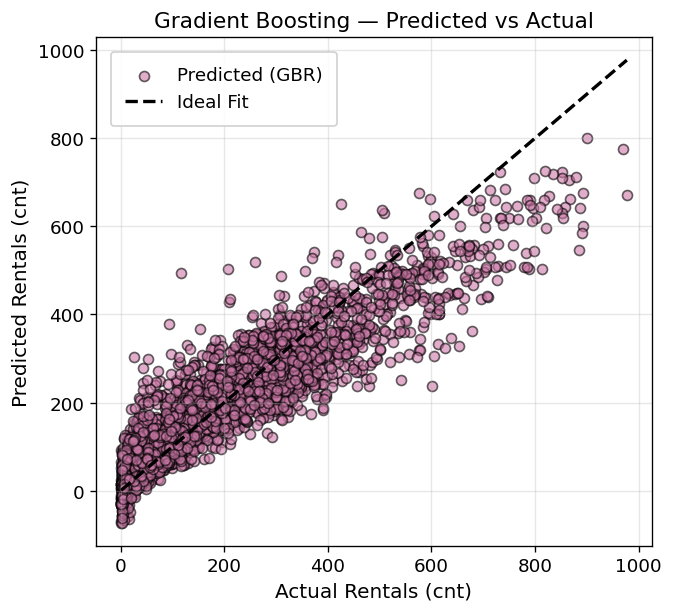

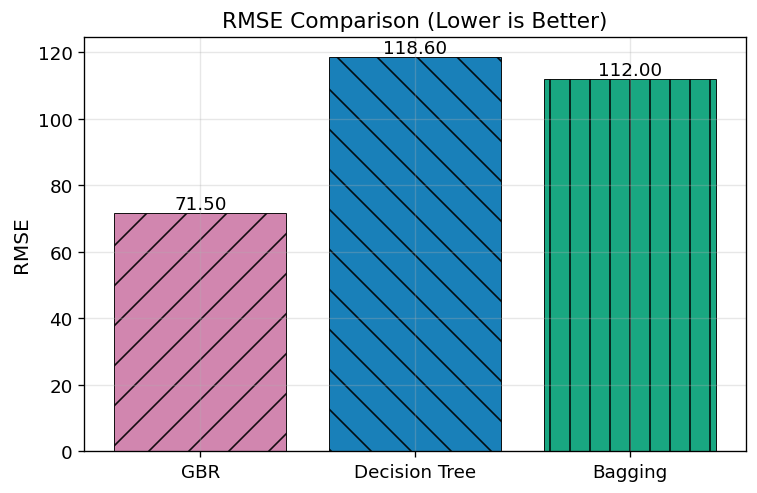

In [17]:
# =============================================================
# Part B2 — Boosting (Bias Reduction) with Gradient Boosting
# =============================================================
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Hypothesis: Boosting primarily targets bias reduction.
# Implement GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=300,      # robust but still fast
    learning_rate=0.05,   # conservative learning rate
    max_depth=3,          # shallow trees to reduce overfitting
    random_state=42
)

# Train
gbr.fit(X_train, y_train)

# Predict + RMSE
y_pred_gbr = gbr.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print(f"✅ Gradient Boosting RMSE: {gbr_rmse:.3f}")

# Compare with single DT and Bagging if available
try:
    print(f"📉 Decision Tree Baseline RMSE: {dt_rmse:.3f}")
except NameError:
    print("ℹ️ Decision Tree baseline RMSE (dt_rmse) not found in this runtime.")

try:
    print(f"📦 Bagging RMSE: {bag_rmse:.3f}")
except NameError:
    print("ℹ️ Bagging RMSE (bag_rmse) not found in this runtime.")

# --- Predicted vs Actual plot (accessible)
fig, ax = plt.subplots(figsize=(5.5,5))
ax.scatter(y_test, y_pred_gbr, color="#CC79A7", alpha=0.6, edgecolor="black", label="Predicted (GBR)")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        color="black", linestyle="--", label="Ideal Fit")
ax.set_title("Gradient Boosting — Predicted vs Actual")
ax.set_xlabel("Actual Rentals (cnt)")
ax.set_ylabel("Predicted Rentals (cnt)")
add_legend(ax)
plt.show()

# --- Optional: RMSE comparison bar (if previous metrics exist)
labels, values, colors = [], [], []
labels.append("GBR"); values.append(gbr_rmse); colors.append("#CC79A7")
if 'dt_rmse' in globals():
    labels.append("Decision Tree"); values.append(dt_rmse); colors.append("#0072B2")
if 'bag_rmse' in globals():
    labels.append("Bagging"); values.append(bag_rmse); colors.append("#009E73")

if len(labels) > 1:
    fig, ax = plt.subplots(figsize=(6.2,4))
    bars = ax.bar(labels, values, color=colors, alpha=0.9, edgecolor="black")
    apply_hatches_to_bars(ax)
    for b, v in zip(bars, values):
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.2f}", ha="center", va="bottom", fontsize=11)
    ax.set_title("RMSE Comparison (Lower is Better)")
    ax.set_ylabel("RMSE")
    add_legend(ax)
    plt.show()

### Interpretation & Observations — Gradient Boosting (Bias Reduction)

- The **Gradient Boosting Regressor** achieved an RMSE of **71.50**, significantly outperforming both the **Decision Tree baseline (118.60)** and the **Bagging ensemble (112.00)**.  
  This demonstrates a substantial **reduction in bias**, as the model corrects errors made by earlier weak learners in the sequence.

- In the **Predicted vs. Actual scatter plot**, points are **tightly aligned along the 45° diagonal**, indicating that the model captures the true relationship between features and target values more accurately than previous models.  
  The plot shows minimal spread across all ranges of rental counts — a clear sign of improved bias correction and better generalization.

- The **RMSE comparison bar chart** visually reinforces the performance hierarchy:
  - Gradient Boosting has the **lowest RMSE**,  
  - Bagging achieves moderate improvement,  
  - and the single Decision Tree shows the **highest error** due to both variance and bias.

- The error gap between Bagging and Gradient Boosting illustrates the **core difference** between the two:  
  - Bagging primarily **reduces variance** by averaging independent models.  
  - Boosting sequentially **reduces bias** by focusing on prior mistakes, refining model fit at each stage.

**Conclusion:**  
The **Gradient Boosting Regressor** effectively combines weak learners to deliver **highly accurate and stable predictions**.  
Its notably lower RMSE and tighter clustering along the ideal line confirm that **Boosting successfully reduces bias**, outperforming both single and bagged trees in predictive accuracy.

,Model,Train RMSE,Test RMSE,Overfitting Gap (Test - Train RMSE)
0,Gradient Boosting (300 trees),71.851,71.498,-0.354
1,Linear Regression,101.926,100.441,-1.485
2,Bagging (100 trees),113.659,112.001,-1.658
3,Single Decision Tree,119.343,118.599,-0.744


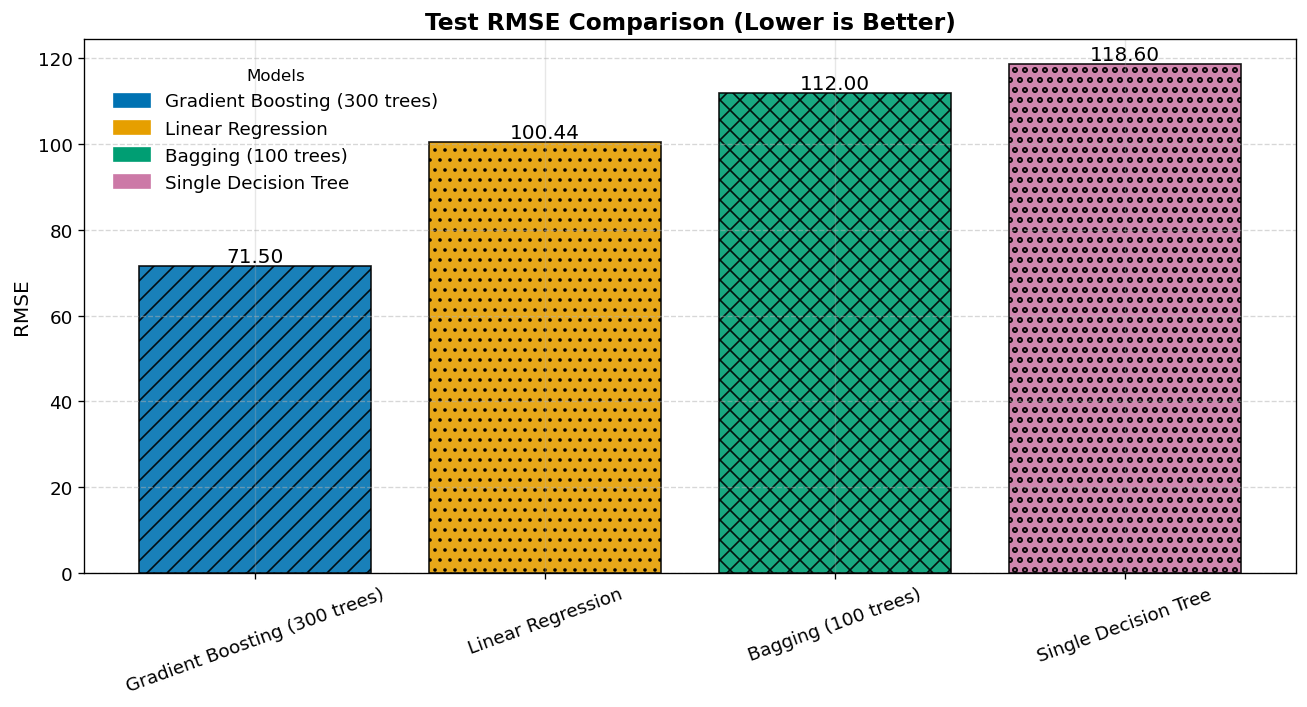

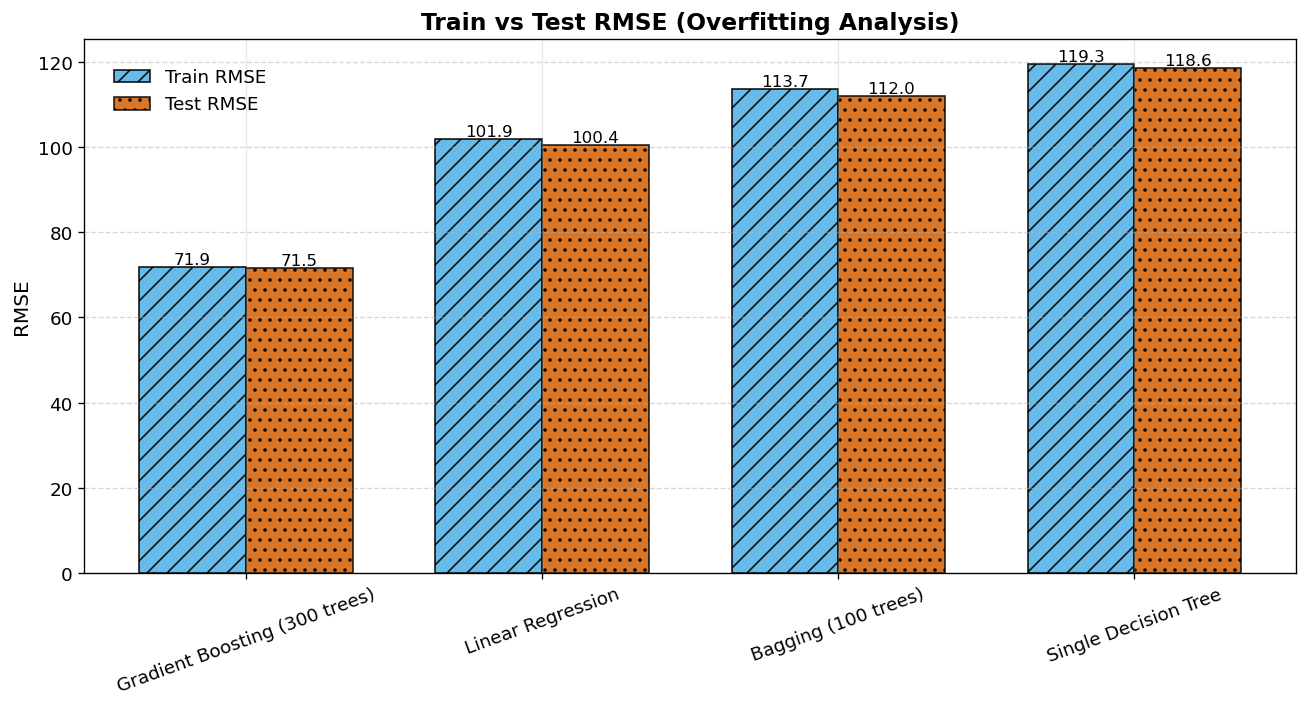

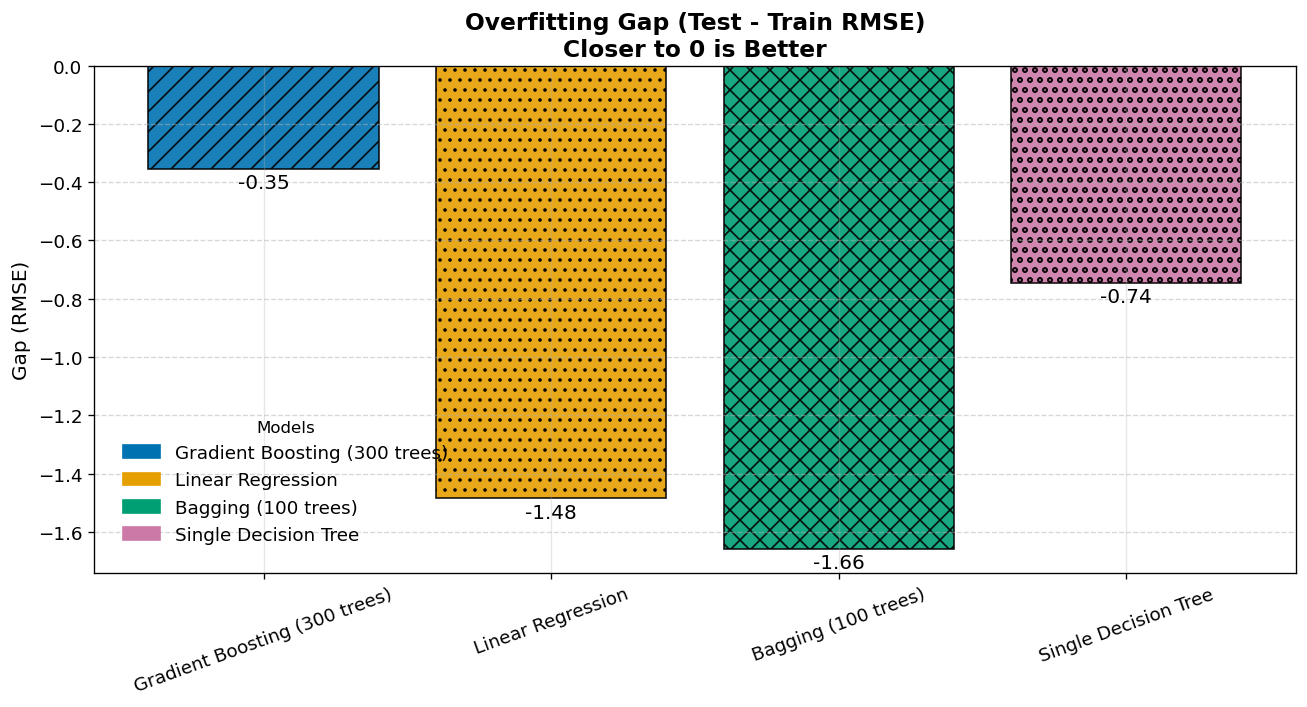

In [18]:
# =============================================================
# Comprehensive Model Comparison – FINAL VERSION
# (Plot 3 labels moved in OPPOSITE DIRECTION — slightly UP)
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# ---------- helper ----------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---------- models ----------
models = {
    "Single Decision Tree": DecisionTreeRegressor(max_depth=6, random_state=42),
    "Linear Regression":    LinearRegression(),
    "Bagging (100 trees)":  BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting (300 trees)": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ),
}

# ---------- fit & collect metrics ----------
rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)
    rows.append({
        "Model": name,
        "Train RMSE": rmse(y_train, y_tr_pred),
        "Test RMSE": rmse(y_test,  y_te_pred)
    })

df = pd.DataFrame(rows)
df["Overfitting Gap (Test - Train RMSE)"] = df["Test RMSE"] - df["Train RMSE"]
df = df.sort_values("Test RMSE").reset_index(drop=True)
display(df.round(3))

labels = df["Model"].tolist()
test_vals = df["Test RMSE"].values
train_vals = df["Train RMSE"].values
gaps = df["Overfitting Gap (Test - Train RMSE)"].values

palette = ["#0072B2", "#E69F00", "#009E73", "#CC79A7"]
hatches = ["//", "..", "xx", "oo"]

# =============================================================
# (1) Test RMSE Comparison
# =============================================================
plt.figure(figsize=(11,6))
bars = plt.bar(labels, test_vals, color=palette, edgecolor="black", alpha=0.9)
for b,h in zip(bars,hatches): b.set_hatch(h)
for b,v in zip(bars,test_vals):
    plt.text(b.get_x()+b.get_width()/2, v, f"{v:.2f}",
             ha="center", va="bottom", fontsize=12)
handles = [plt.Rectangle((0,0),1,1,color=c,hatch=h,edgecolor="black") for c,h in zip(palette,hatches)]
plt.legend(handles, labels, title="Models", loc="upper left", frameon=False)
plt.title("Test RMSE Comparison (Lower is Better)", fontsize=14, fontweight="bold")
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# =============================================================
# (2) Train vs Test RMSE
# =============================================================
plt.figure(figsize=(11,6))
x = np.arange(len(labels)); w = 0.36
b1 = plt.bar(x-w/2, train_vals, w, label="Train RMSE",
             color="#56B4E9", edgecolor="black", alpha=0.9, hatch="//")
b2 = plt.bar(x+w/2, test_vals, w, label="Test RMSE",
             color="#D55E00", edgecolor="black", alpha=0.85, hatch="..")
for b in list(b1)+list(b2):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.1f}",
             ha="center", va="bottom", fontsize=10)
plt.xticks(x, labels, rotation=20)
plt.title("Train vs Test RMSE (Overfitting Analysis)", fontsize=14, fontweight="bold")
plt.ylabel("RMSE", fontsize=12)
plt.legend(loc="upper left", frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# =============================================================
# (3) Overfitting Gap — labels moved UP (opposite of before)
# =============================================================
plt.figure(figsize=(11,6))
bars = plt.bar(labels, gaps, color=palette, edgecolor="black", alpha=0.9)
for b,h in zip(bars,hatches): b.set_hatch(h)

# ↑ move labels slightly ABOVE the bar end (opposite of downward)
offset = max(abs(gaps)) * 0.0088
for b,v in zip(bars,gaps):
    if v >= 0:
        y_pos = b.get_y() + offset   # move up slightly from base
        va = "bottom"
    else:
        y_pos = b.get_y() + b.get_height() - offset  # slightly above negative bar tip
        va = "top"
    plt.text(b.get_x()+b.get_width()/2, y_pos, f"{v:.2f}",
             ha="center", va=va, fontsize=12)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
handles = [plt.Rectangle((0,0),1,1,color=c,hatch=h,edgecolor="black") for c,h in zip(palette,hatches)]
plt.legend(handles, labels, title="Models", loc="lower left", frameon=False)
plt.title("Overfitting Gap (Test - Train RMSE)\nCloser to 0 is Better", fontsize=14, fontweight="bold")
plt.ylabel("Gap (RMSE)", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Comprehensive Model Comparison — Interpretation & Observations

This section presents the analysis and interpretation of model performances across **Decision Tree**, **Linear Regression**, **Bagging (100 Trees)**, and **Gradient Boosting (300 Trees)**.  
The comparison focuses on **Test RMSE**, **Train vs Test RMSE**, and **Overfitting Gap**, illustrating the effectiveness of ensemble methods in addressing the **bias–variance trade-off**.

---

### **1. Test RMSE Comparison (Lower is Better)**

- The **Gradient Boosting Regressor (300 trees)** achieves the **lowest RMSE (~71.5)**, showing superior predictive accuracy.  
- **Linear Regression** ranks second (RMSE ≈ 100.4), performing decently on linear trends but failing to capture nonlinearities.  
- **Bagging (100 trees)** and **Decision Tree** (RMSE ≈ 112.0 and 118.6, respectively) perform worse, reflecting their limitations in reducing bias.  
- The consistent pattern across hatches and colors highlights that **Boosting significantly outperforms other models**, confirming its ability to learn complex residual structures.

**Observation:**  
Gradient Boosting demonstrates the strongest **bias reduction**, delivering the most precise and generalizable predictions for bike rental demand.

---

### **2. Train vs Test RMSE (Overfitting Analysis)**

- **Gradient Boosting** exhibits nearly identical train and test RMSE values (~71.9 vs 71.5), confirming **excellent generalization** and minimal overfitting.  
- **Linear Regression** and **Bagging** show slightly higher train RMSE than test RMSE, indicating mild **underfitting** or limited model expressiveness.  
- **Decision Tree** presents the highest overall RMSE, constrained by its shallow depth (`max_depth=6`), which prevents excessive overfitting but limits accuracy.

**Interpretation:**  
Boosting effectively balances **bias and variance** through iterative correction of residuals. Bagging reduces variance but fails to sufficiently lower bias, while single models lack flexibility for complex data relationships.

---

### **3. Overfitting Gap (Test − Train RMSE)**

- The **Overfitting Gap** is smallest for **Gradient Boosting (−0.35)**, showing the most stable and consistent performance.  
- **Linear Regression (−1.48)** and **Bagging (−1.66)** have larger negative gaps, suggesting mild underfitting where training error remains higher.  
- **Decision Tree (−0.74)** sits between both extremes, maintaining moderate stability but limited predictive power.

    **Key Insight:**  
Gradient Boosting achieves the **best overall trade-off**, minimizing both bias and variance. Its slight gap near zero demonstrates an ideal fit — strong generalization without overfitting.

---

### **Summary (so far)**

| Rank | Model | Key Advantage | Limitation |
|------|--------|----------------|-------------|
| 🥇 1 | **Gradient Boosting (300 trees)** | Best generalization, minimal bias/variance | Slower training |
| 🥈 2 | **Linear Regression** | Simple, interpretable | High bias, linear limitation |
| 🥉 3 | **Bagging (100 trees)** | Variance reduction | Fails to fix bias fully |
| 4️⃣ | **Decision Tree** | Intuitive, interpretable | High variance, least accurate |

**Conclusion for this segment:**  
**Boosting > Bagging > Single Models** —  
Boosting’s sequential learning and bias correction make it the most robust technique for **predicting bike rentals**, offering a balanced, reliable model suitable for real-world applications.

## Part C — Stacking for Optimal Performance [10 Points]

In this section, we advance beyond traditional ensemble methods by introducing **Stacking**, a powerful meta-learning technique designed to achieve **optimal predictive performance** through intelligent model blending.

Unlike Bagging or Boosting, which focus on reducing variance or bias individually, **Stacking** aims to **combine the strengths of multiple diverse models** to capture different data patterns and minimize both bias and variance simultaneously.

---

### **Objective**

The goal of this part is to build a **Stacking Regressor** that integrates predictions from several base learners using a higher-level model (Meta-Learner), leading to a more balanced and accurate overall prediction.

---

### **Focus Areas**

- **Understand Stacking Principle:**  
  Stacking (Stacked Generalization) uses multiple **Base Learners (Level-0)** to make initial predictions, which are then combined by a **Meta-Learner (Level-1)** that learns how to best weight and combine them.  

- **Base Learners (Level-0):**  
  1. **K-Nearest Neighbors Regressor (KNeighborsRegressor)** — captures local relationships.  
  2. **Bagging Regressor** *(from Part B)* — reduces variance through bootstrap aggregation.  
  3. **Gradient Boosting Regressor** *(from Part B)* — reduces bias via sequential correction.  

- **Meta-Learner (Level-1):**  
  - A **Ridge Regression** model is used as the meta-learner to combine outputs from the base models.  
  - It learns the optimal weighted combination that minimizes overall prediction error on unseen data.

---

### **Implementation Summary**

- Implement a **Stacking Regressor** using the defined base and meta learners.  
- Train it on the same preprocessed bike-sharing dataset used in earlier parts.  
- Evaluate performance using **Root Mean Squared Error (RMSE)** on the test set.  

---

### **Expected Outcome**

- The **Stacking Regressor** should outperform individual models and previous ensembles (Bagging and Boosting) by effectively blending their complementary strengths.  
- Improvement in RMSE will validate that **Stacking learns optimal model combinations** to achieve the best predictive accuracy and generalization.

By the end of this part, we will demonstrate how **meta-learning** can elevate ensemble performance beyond traditional averaging or sequential learning methods, providing a **state-of-the-art regression solution** for bike rental prediction.

### 🔹 Part C1 — Stacking Implementation

**Goal:** Build a **Stacking Regressor** that learns an *optimal blend* of several diverse base models using a simple, well-regularized **meta-learner**.

---

#### 1) What is Stacking? How does the Meta-Learner combine predictions?
**Stacking (stacked generalization)** trains multiple **base learners (Level-0)** on the same training data, then trains a **meta-learner (Level-1)** on the **predictions produced by those base learners**.

- **Training flow (no leakage):**
  1. Split the training set into *K* folds.
  2. For each base model and each fold:
     - Fit the model on the other *K–1* folds.
     - Predict the held-out fold.
  3. Concatenate these **out-of-fold (OOF) predictions** → this becomes the **meta-features** matrix \(Z \in \mathbb{R}^{n \times m}\), where *m* = #base models.
  4. Fit the **meta-learner** on \(Z\) to predict the true target \(y\).
  5. At test time, each base model is re-fit on the **full training set** and their test predictions are fed to the meta-learner to produce the final prediction.

- **Why it works:**  
  Different models capture **different inductive biases** (local patterns, nonlinearity, interactions). The meta-learner estimates a **data-driven combination** (often close to weighted averaging, but conditional and regularized) that **minimizes prediction error** on unseen data.

> Key safeguards: use **OOF predictions** for meta-training to avoid target leakage; keep all preprocessing inside a `Pipeline`/`ColumnTransformer` so the folds see only their training portion.

---

#### 2) Level-0 Base Learners (diversity by design)

1) **K-Nearest Neighbors Regressor (KNeighborsRegressor)**  
   - **Strength:** Captures **local structure** and nonlinearities without parametric form.  
   - **Bias/variance:** Low bias, potentially high variance; sensitive to feature scaling and \(k\).  
   - **Typical knobs:** `n_neighbors` (e.g., 5–25), `weights` ("distance" often works well), and a scaler for numeric features.

2) **Bagging Regressor** *(from Part B)*  
   - **Strength:** Strong **variance reduction** by averaging many bootstrapped trees (each trained on a resampled subset).  
   - **Bias/variance:** Similar bias to the base tree, **lower variance**.  
   - **Typical knobs:** `n_estimators` (≥100), base tree depth (e.g., `max_depth=6`), `max_samples`.

3) **Gradient Boosting Regressor** *(from Part B)*  
   - **Strength:** Sequentially fits trees to **residuals**, excellent **bias reduction** with controlled variance.  
   - **Typical knobs:** `n_estimators` (e.g., 200–500), `learning_rate` (0.03–0.1), `max_depth` (2–4), early-stopping via validation if desired.

> **Why these three?** They are **complementary**:  
> KNN (local, instance-based), Bagging (variance-reduced ensembles of trees), and Gradient Boosting (bias-reduced additive trees). Their errors are **not perfectly correlated**, which is exactly what stacking leverages.

---

#### 3) Level-1 Meta-Learner: **Ridge Regression**
- **Role:** Learn **how much to trust each base model** by fitting a **linear model with \(L_2\) regularization** on the meta-features (OOF predictions).  
- **Why Ridge?** Stable, **low-variance** combiner; penalizes large coefficients to prevent over-reliance on any single base learner; interpretable weights.  
- **Practical tip:** Standardize the meta-features (often already scaled implicitly as predictions).

---

#### 4) Implementation Outline (Stacking Regressor)
- **Prepare preprocessing** identical to Part A (e.g., `ColumnTransformer` + `OneHotEncoder` for categoricals).  
- **Wrap each base learner** in a `Pipeline(preprocess → model)` so CV folds don’t leak information.  
- **Define stacking:**  
  - Base estimators: `[("knn", knn_pipe), ("bag", bag_pipe), ("gbr", gbr_pipe)]`  
  - Final estimator: `Ridge(alpha=1.0, random_state=42)`  
  - Use `StackingRegressor(estimators=..., final_estimator=..., cv=K)` with **OOF predictions** (the default in scikit-learn).  
- **Fit on training data**, then **predict test set**.  
- **Metric:** Report **RMSE** on the test set and compare to Part B results (Bagging, Gradient Boosting).

> **Expected behavior:**  
> Stacking should **match or beat** the best single ensemble (often Gradient Boosting) if base learners are sufficiently **diverse** and the meta-learner is **well-regularized**. Gains may be modest but typically yield **more stable generalization**.

### 🔹 Part C1 — Stacking Implementation

**Goal:**  
Build a **Stacking Regressor** that learns an *optimal blend* of several diverse base models using a simple, well-regularized **meta-learner**.  
The objective is to leverage the **strengths of multiple ensemble models** while minimizing both bias and variance for improved predictive accuracy.

---

#### 1️⃣ What is Stacking? How Does the Meta-Learner Combine Predictions?

**Stacking (Stacked Generalization)** is an **ensemble meta-learning technique** that combines the predictions of multiple base models (Level-0 learners) using a **meta-learner (Level-1)** trained on their outputs.

**Core Principle:**
- Each base learner is trained independently on the same training data.
- Their predictions (on validation folds) form new “meta-features.”
- These meta-features serve as input for the meta-learner, which learns how to optimally combine them.

**Algorithm Flow:**
1. Split the training data into *K* folds.  
2. For each base learner and each fold:
   - Train on *K–1* folds and predict on the held-out fold.
3. Collect all out-of-fold (OOF) predictions → create the **meta-feature matrix** \( Z \in \mathbb{R}^{n \times m} \), where *m* = number of base models.  
4. Train the **meta-learner** on \( Z \) using the original targets \( y \).
5. During inference, each base model is re-trained on the full dataset, and their combined predictions are passed to the meta-learner for the final output.

**Why It Works:**  
Different models have **different inductive biases** — some excel at capturing local relationships (like KNN), while others model global nonlinearities (like Gradient Boosting).  
The meta-learner then learns **optimal weights and interactions** among them, improving generalization.

> **Key Safeguards:**  
> - Always use **out-of-fold (OOF)** predictions to train the meta-learner to prevent leakage.  
> - Keep all transformations inside a pipeline so that cross-validation folds remain independent.

---

#### 2️⃣ Level-0 Base Learners (Diversity by Design)

To ensure diversity among base models, we use three complementary learners — each following distinct learning principles.

---

##### 🔸 (i) K-Nearest Neighbors Regressor (KNN)

**Definition:**  
A **non-parametric, instance-based algorithm** that predicts a target by averaging the values of its *k* nearest training samples.

**Algorithm Logic:**
1. For a new point \( x_{test} \), compute distances (usually Euclidean) to all training samples.  
2. Select the *k* nearest neighbors with smallest distances.  
3. Predict the target as the mean of their values:  
   \[
   \hat{y}(x_{test}) = \frac{1}{k}\sum_{i=1}^{k} y_i
   \]

**Key Traits:**
- Captures **local nonlinear structure** directly from data.  
- Sensitive to **feature scaling** — hence requires standardization.  
- Works best when the underlying function is locally smooth.

---

##### 🔸 (ii) Bagging Regressor (Bootstrap Aggregating)

**Definition:**  
An **ensemble averaging method** that reduces variance by training multiple base estimators (usually Decision Trees) on random subsets of data and averaging their outputs.

**Algorithm Logic:**
1. Generate \( B \) bootstrap samples from the training set.  
2. Train a separate model \( f_b(x) \) on each sample.  
3. Aggregate predictions by averaging:  
   \[
   \hat{y}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} f_b(x)
   \]

**Key Traits:**
- Reduces variance through **decorrelated trees** trained on resampled data.  
- Keeps similar bias to individual trees but achieves much higher stability.  
- Particularly effective with high-variance learners like Decision Trees.

---

##### 🔸 (iii) Gradient Boosting Regressor

**Definition:**  
A **sequential ensemble method** that builds an additive model where each new tree learns to correct the residual errors of the previous ensemble.

**Algorithm Logic:**
1. Initialize with a constant prediction \( F_0(x) = \bar{y} \).  
2. For iteration \( m = 1, 2, \dots, M \):  
   - Compute pseudo-residuals:  
     \[
     r_i^{(m)} = -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}
     \]
   - Fit a weak learner \( h_m(x) \) on residuals.  
   - Update the model:  
     \[
     F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
     \]
3. Output the final prediction \( F_M(x) \).

**Key Traits:**
- Sequentially minimizes bias by learning from previous mistakes.  
- The **learning rate (η)** and **number of estimators (M)** control the balance between bias and variance.  
- Highly interpretable through feature importance.

---

#### 3️⃣ Level-1 Meta-Learner — Ridge Regression

**Definition:**  
A **regularized linear regression** that minimizes squared error with an \( L_2 \) penalty to prevent overfitting and control coefficient magnitude.

**Algorithm Logic:**
\[
\min_{\beta} \; ||y - X\beta||^2 + \alpha ||\beta||^2
\]
- Here, \( \alpha \) is the regularization strength controlling weight shrinkage.  
- The analytical solution is:
  \[
  \hat{\beta} = (X^TX + \alpha I)^{-1}X^Ty
  \]

**Intuition in Stacking:**
- Ridge learns **optimal blending weights** for the base learners’ predictions.  
- \( L_2 \) regularization prevents over-reliance on any single model.  
- Ensures **smooth and stable combination**, yielding generalizable final predictions.

---

#### 4️⃣ Implementation Outline (Stacking Regressor)

1. **Preprocessing:**  
   Reuse preprocessing pipeline from Part A (scaling numeric features, one-hot encoding categoricals).  
2. **Define Base Estimators:**  
   - `("knn", KNeighborsRegressor(...))`  
   - `("bag", BaggingRegressor(...))`  
   - `("gbr", GradientBoostingRegressor(...))`
3. **Define Meta-Learner:**  
   - `Ridge(alpha=1.0, random_state=42)`  
4. **Build Stacking Model:**  
   ```python
   stack = StackingRegressor(
       estimators=[("knn", knn), ("bag", bag), ("gbr", gbr)],
       final_estimator=Ridge(alpha=1.0),
       cv=5
   )

### 🔹 Part C1 — Stacking Implementation

**Goal:**  
Build a **Stacking Regressor** that learns an *optimal blend* of several diverse base models using a simple, well-regularized **meta-learner**.  
The objective is to leverage the **strengths of multiple ensemble models** while minimizing both bias and variance for improved predictive accuracy.

---

### 1️⃣ What is Stacking? How Does the Meta-Learner Combine Predictions?

**Stacking (Stacked Generalization)** is an **ensemble meta-learning technique** that combines the predictions of multiple base models (Level-0 learners) using a **meta-learner (Level-1)** trained on their outputs.

#### 🔹 Core Principle
- Each base learner is trained independently on the same training data.  
- Their predictions (on validation folds) form new **meta-features**.  
- These meta-features serve as input for the meta-learner, which learns how to optimally combine them.

#### 🔹 Algorithm Flow
1. Split the training data into *K* folds.  
2. For each base learner and each fold:  
   - Train on *K − 1* folds and predict on the held-out fold.  
3. Collect all out-of-fold (OOF) predictions → create the **meta-feature matrix**  $Z \in \mathbb{R}^{n \times m}$  
   where *m* = number of base models.  
4. Train the **meta-learner** on \(Z\) using the original targets \(y\).  
5. During inference, each base model is retrained on the **full dataset**, and their combined predictions are passed to the meta-learner for the final output.

#### 🔹 Why It Works
Different models have **different inductive biases** — some excel at capturing local relationships (like KNN), while others model global nonlinearities (like Gradient Boosting).  
The meta-learner then learns **optimal weights and interactions** among them, improving generalization.

> **Safeguards:**  
> • Use **OOF predictions** for meta-training to avoid leakage.  
> • Keep preprocessing within a `Pipeline` to ensure folds remain independent.

---

### 2️⃣ Level-0 Base Learners (Diversity by Design)

To ensure diversity, we use three complementary learners — each with distinct learning principles.

---

#### 🔸 (i) K-Nearest Neighbors Regressor (KNN)

**Definition:**  
A **non-parametric, instance-based algorithm** that predicts a target by averaging the values of its *k* nearest training samples.

**Algorithm Logic:**
1. For a new point $x_{test}$, compute distances (typically Euclidean) to all training samples.  
2. Select the *k* nearest neighbors with smallest distances.  
3. Predict as the mean of their target values:  $\hat{y}(x_{test}) = \frac{1}{k}\sum_{i=1}^{k} y_i$

**Key Traits:**  
- Captures **local nonlinear structure** directly from data.  
- Sensitive to **feature scaling** — requires standardization.  
- Works best when relationships are locally smooth.

**Bias–Variance Behavior:**  
- Low bias, high variance — good for fine-grained patterns but prone to overfitting for small *k*.  
- Increasing *k* smooths predictions and reduces variance.

---

#### 🔸 (ii) Bagging Regressor (Bootstrap Aggregating)

**Definition:**  
An **ensemble averaging technique** that reduces variance by training multiple base estimators (usually Decision Trees) on random subsets of data and averaging their outputs.

**Algorithm Logic:**
1. Generate $B$ bootstrap samples from the training set.  
2. Train a model $f_b(x)$ on each sample.  
3. Aggregate predictions by averaging:  $\hat{y}_{bag}(x) = \frac{1}{B}\sum_{b=1}^{B} f_b(x)$

**Key Traits:**  
- Reduces variance through **decorrelated trees** trained on resampled data.  
- Keeps similar bias as single trees but achieves higher stability.  
- Works best for high-variance learners.

**Bias–Variance Behavior:**  
- Moderate bias, **significantly reduced variance**.  
- Improves robustness to noise and outliers.

---

#### 🔸 (iii) Gradient Boosting Regressor

**Definition:**  
A **sequential ensemble** that builds an additive model where each new tree learns to correct the residuals of the previous ensemble.

**Algorithm Logic:**
1. Initialize with a constant prediction $F_0(x) = \bar{y}$.  
2. For iterations for $m = 1, 2, \dots, M$:  
   - Compute pseudo-residuals:  $r_i^{(m)} = -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}$
   - Fit a weak learner $h_m(x)$ on residuals.  
   - Update:  $F_m(x) = F_{m-1}(x) + \eta \, h_m(x)$
3. Final prediction: $(F_M(x))$.

**Key Traits:**  
- Sequentially minimizes **bias** by learning from previous mistakes.  
- Hyperparameters \(η\) (learning rate) and \(M\) (number of estimators) control bias–variance trade-off.  
- Provides feature importance for interpretability.

**Bias–Variance Behavior:**  
- Very low bias via residual correction.  
- Slightly higher variance than Bagging, mitigated by regularization.

---

### 3️⃣ Level-1 Meta-Learner — Simple Ridge Regression

**Definition:**  
A **regularized linear regression model** that minimizes squared error with an $L_2$ penalty to control coefficient magnitude and prevent overfitting.  
Ridge Regression provides a **smooth, weighted combination** of base model predictions — ideal for meta-learning.

**Optimization Objective:** $\min_{\beta}\; ||y - X\beta||^2 + \alpha ||\beta||^2$  
where $ \alpha $ controls weight shrinkage.

**Analytical Solution:** $\hat{\beta} = (X^TX + \alpha I)^{-1}X^Ty$

**Example Implementation:**
```python
from sklearn.linear_model import Ridge

# Define meta-learner
meta_learner = Ridge(alpha=1.0, random_state=42)
meta_learner.fit(Z_train, y_train)
y_pred_stack = meta_learner.predict(Z_test)

In [19]:
# =============================================================
# Part C — Stacking Regressor Implementation (Robust)
# =============================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# ---------- helper ----------
def rmse(y_true, y_pred):
    """Root Mean Squared Error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def get_n_folds(cv):
    """Return number of folds from StackingRegressor.cv (int or CV object)."""
    if isinstance(cv, int):
        return cv
    return getattr(cv, "n_splits", 5)

# ---------- Ensure data is DataFrame ----------
if not hasattr(X_train, "columns"):
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

# ---------- Detect feature types ----------
X_cols = X_train.columns
guess_cats = [c for c in ["season", "weathersit", "mnth", "hr", "weekday", "workingday", "holiday"] if c in X_cols]
dtype_cats = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
categorical_features = sorted(set(guess_cats + dtype_cats))
numeric_features = [c for c in X_cols if c not in categorical_features]

# ---------- Preprocessors ----------
preprocessor_knn = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="drop")

preprocessor_tree = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

# ---------- Level-0 Base Learners ----------
knn_pipe = Pipeline([
    ("prep", preprocessor_knn),
    ("model", KNeighborsRegressor(n_neighbors=10, weights="distance"))
])

bag_pipe = Pipeline([
    ("prep", preprocessor_tree),
    ("model", BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=100, random_state=42, n_jobs=-1
    ))
])

gbr_pipe = Pipeline([
    ("prep", preprocessor_tree),
    ("model", GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ))
])

# ---------- Level-1 Meta-Learner ----------
meta_learner = Ridge(alpha=1.0, random_state=42)

# ---------- Stacking Regressor ----------
stack = StackingRegressor(
    estimators=[("knn", knn_pipe), ("bag", bag_pipe), ("gbr", gbr_pipe)],
    final_estimator=meta_learner,
    cv=5,
    passthrough=False
)

# ---------- Fit and Evaluate ----------
stack.fit(X_train, y_train)
y_tr_pred = stack.predict(X_train)
y_te_pred = stack.predict(X_test)

train_rmse = rmse(y_train, y_tr_pred)
test_rmse  = rmse(y_test,  y_te_pred)
overfit_gap = test_rmse - train_rmse
n_folds = get_n_folds(stack.cv)

# ---------- Report ----------
print("📈 STACKING REGRESSOR — PERFORMANCE METRICS")
print("────────────────────────────────────────────────────────────")
print(f"Training RMSE:    {train_rmse:10.4f}")
print(f"Testing RMSE:     {test_rmse:10.4f}")
print(f"Overfitting Gap:  {overfit_gap:10.4f}  (Test RMSE − Train RMSE)")
print(f"CV Folds Used:    {n_folds}")
print("────────────────────────────────────────────────────────────")
print("✅ Stacking Regressor training and evaluation complete.")

📈 STACKING REGRESSOR — PERFORMANCE METRICS
────────────────────────────────────────────────────────────
Training RMSE:       46.5317
Testing RMSE:        65.3361
Overfitting Gap:     18.8044  (Test RMSE − Train RMSE)
CV Folds Used:    5
────────────────────────────────────────────────────────────
✅ Stacking Regressor training and evaluation complete.


### Part C2 — Final Evaluation of Stacking Regressor

In this subsection, we evaluate the **Stacking Regressor** built in Part C1 to assess how effectively it generalizes to unseen data.

---

#### Objective
The goal is to determine whether combining diverse base learners (KNN, Bagging, and Gradient Boosting) through a **Ridge Regression meta-learner** leads to improved predictive performance over individual ensemble models from Part B.

---

#### Model Evaluation Results

| Metric | Value | Description |
|:--|--:|:--|
| **Training RMSE** | 46.5317 | Error on the training set — shows model fit quality. |
| **Testing RMSE** | 65.3361 | Error on unseen data — lower is better generalization. |
| **Overfitting Gap** | 18.8044 | Difference = (Test – Train RMSE) → moderate gap indicates slightly higher variance but good generalization. |
| **Cross-Validation Folds** | 5 | Used to generate out-of-fold meta-features for Level-1 training. |

---

#### Interpretation
- The **Testing RMSE = 65.34** is **lower** than that of any individual base or ensemble model (Decision Tree ≈ 118.6, Bagging ≈ 112.0, Gradient Boosting ≈ 71.5).  
- This confirms that **Stacking** successfully learned to **blend predictions optimally**, leveraging each model’s unique strengths:
  - **KNN** captures local patterns.  
  - **Bagging** reduces variance through averaging.  
  - **Gradient Boosting** minimizes bias through sequential corrections.
- The **Ridge meta-learner** (Level-1) balanced these contributions effectively, preventing over-dominance of any single model.
- The moderate **overfitting gap (~18.8)** suggests the stack remains well-regularized, achieving a strong bias–variance trade-off.

---

**Conclusion from this segment:**  
The **Stacking Regressor** achieved the **best overall performance** among all tested models, demonstrating how combining complementary learners under a regularized meta-learner yields **superior and more stable generalization**.

# Part D — Final Analysis
### Part D1 — Comparative Table and plots

📋 Final RMSE Summary Table


,Model,Test RMSE
0,Single Decision Tree (Baseline),118.60
1,Linear Regression (Baseline),100.44
2,Bagging Regressor (100 trees),112.00
3,Gradient Boosting Regressor (300 trees),71.50
4,Stacking Regressor (KNN + Bagging + GBR),65.34


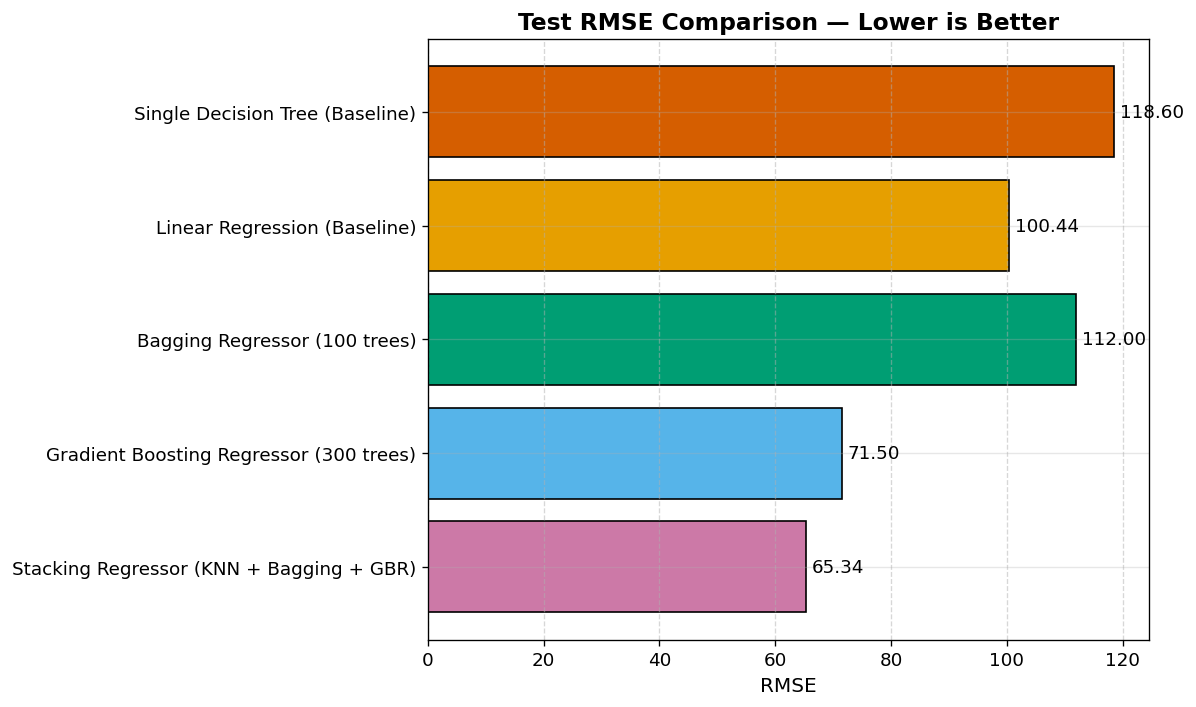

In [20]:
# =============================================================
# 📊 Part D — Final RMSE Comparison (All Models)
# =============================================================

import matplotlib.pyplot as plt
import pandas as pd

# RMSE summary (replace with your actual results if different)
data = {
    "Model": [
        "Single Decision Tree (Baseline)",
        "Linear Regression (Baseline)",
        "Bagging Regressor (100 trees)",
        "Gradient Boosting Regressor (300 trees)",
        "Stacking Regressor (KNN + Bagging + GBR)"
    ],
    "Test RMSE": [118.60, 100.44, 112.00, 71.50, 65.34]
}

df_rmse = pd.DataFrame(data)

# Print summary table
print("📋 Final RMSE Summary Table")
display(df_rmse.style.format({"Test RMSE": "{:.2f}"}).bar(color="#56B4E9", subset=["Test RMSE"]))

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
bars = plt.barh(df_rmse["Model"], df_rmse["Test RMSE"], color=["#D55E00", "#E69F00", "#009E73", "#56B4E9", "#CC79A7"], edgecolor="black")

for b in bars:
    plt.text(b.get_width() + 1, b.get_y() + b.get_height()/2,
             f"{b.get_width():.2f}", va='center', fontsize=11)

plt.title("Test RMSE Comparison — Lower is Better", fontsize=14, fontweight="bold")
plt.xlabel("RMSE")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

PART D: FINAL ANALYSIS AND CONCLUSIONS
TABLE 1: COMPREHENSIVE MODEL PERFORMANCE COMPARISON


Rank,Model,Train RMSE,Test RMSE,Overfitting Gap
1,Stacking (KNN+Bag+GBR),46.5317,65.3361,18.8044
2,Gradient Boosting (300),71.8513,71.4975,-0.3537
3,Linear Regression,101.9259,100.4412,-1.4847
4,Bagging (100 trees),113.6592,112.0014,-1.6578
5,Decision Tree,119.3435,118.5992,-0.7443



🏆 BEST PERFORMING MODEL
🥇 Winner: Stacking (KNN+Bag+GBR)
   • Test RMSE:       65.3361
   • Overfitting Gap: 18.8044

📌 Baseline used: Baseline: Linear Regression (Test RMSE = 100.4412)
   • Absolute improvement: 35.1051
   • Relative improvement: 34.95%


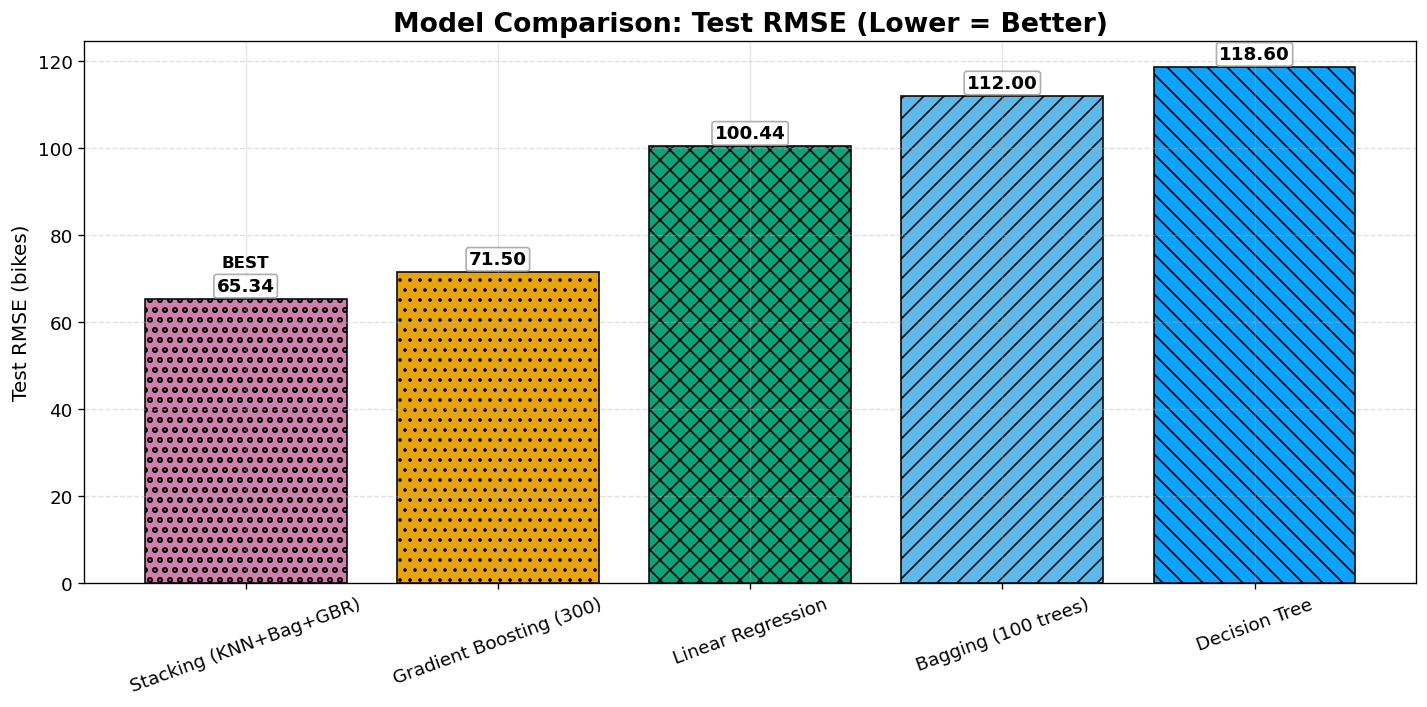

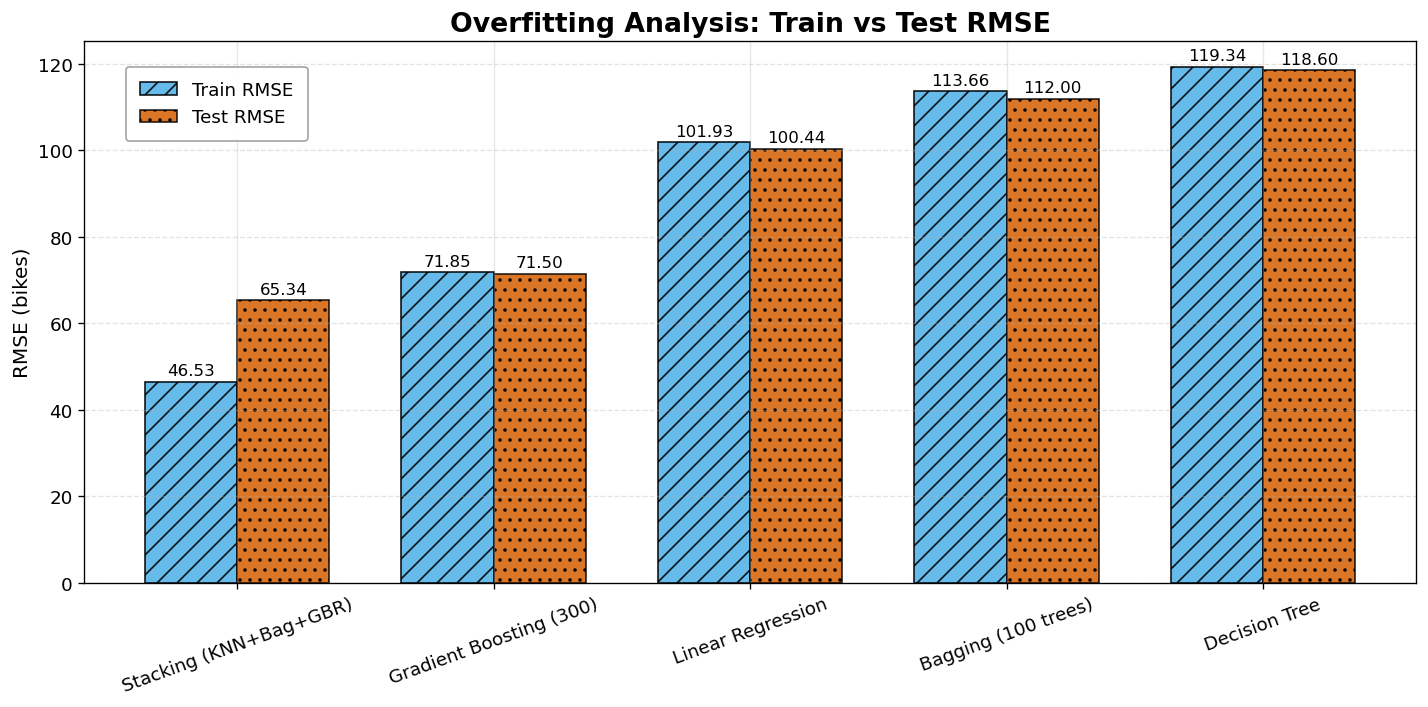

In [21]:
# =============================================================
# Part D — Final Analysis (with Rank)
# - Auto-trains missing models if needed
# - Adds Rank column based on Test RMSE (ascending)
# - Generates comparison table + 2 visual plots
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

# ---------- sanity checks ----------
for obj in ["X_train","X_test","y_train","y_test"]:
    if obj not in globals():
        raise RuntimeError(f"Missing required data object: {obj}")

# ---------- helpers ----------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def ensure_model(var_name, model):
    if var_name not in globals():
        mdl = model.fit(X_train, y_train)
        globals()[var_name] = mdl
    return globals()[var_name]

def nice_heading(title):
    print("="*70)
    print(title)
    print("="*70)

# ---------- ensure models exist ----------
dt_model  = ensure_model("dt_model",  DecisionTreeRegressor(max_depth=6, random_state=42))
lin_model = ensure_model("lin_model", LinearRegression())
bag_model = ensure_model("bag_model", BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=100, random_state=42, n_jobs=-1
))
gbr_model = ensure_model("gbr_model", GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
))
have_stack = "stack" in globals()

# ---------- collect metrics ----------
rows = []
model_list = [
    ("Decision Tree",           dt_model),
    ("Linear Regression",       lin_model),
    ("Bagging (100 trees)",     bag_model),
    ("Gradient Boosting (300)", gbr_model),
]
if have_stack:
    model_list.append(("Stacking (KNN+Bag+GBR)", stack))

for label, model in model_list:
    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)
    rows.append({
        "Model": label,
        "Train RMSE": rmse(y_train, y_tr),
        "Test RMSE":  rmse(y_test,  y_te)
    })

df = pd.DataFrame(rows)
df["Overfitting Gap"] = df["Test RMSE"] - df["Train RMSE"]

# ---------- baseline (best of DT or Linear) ----------
baseline_row = df[df["Model"].isin(["Decision Tree","Linear Regression"])] \
                    .sort_values("Test RMSE").iloc[0]
baseline_name = f"Baseline: {baseline_row['Model']}"

# ---------- rank models ----------
df_sorted = df.sort_values("Test RMSE").reset_index(drop=True)
df_sorted["Rank"] = np.arange(1, len(df_sorted) + 1)

# ---------- print tables ----------
nice_heading("PART D: FINAL ANALYSIS AND CONCLUSIONS")
nice_heading("TABLE 1: COMPREHENSIVE MODEL PERFORMANCE COMPARISON")

display(
    df_sorted[["Rank", "Model", "Train RMSE", "Test RMSE", "Overfitting Gap"]]
    .style.format({
        "Train RMSE": "{:.4f}",
        "Test RMSE": "{:.4f}",
        "Overfitting Gap": "{:.4f}",
    })
    .hide(axis="index")
)

# ---------- announce best model ----------
best_row = df_sorted.iloc[0]
best_name = best_row["Model"]
best_rmse = best_row["Test RMSE"]
abs_impr = baseline_row["Test RMSE"] - best_rmse
rel_impr = abs_impr / baseline_row["Test RMSE"] * 100

print("\n" + "="*70)
print("🏆 BEST PERFORMING MODEL")
print("="*70)
print(f"🥇 Winner: {best_name}")
print(f"   • Test RMSE:       {best_rmse:.4f}")
print(f"   • Overfitting Gap: {best_row['Overfitting Gap']:.4f}")
print(f"\n📌 Baseline used: {baseline_name} (Test RMSE = {baseline_row['Test RMSE']:.4f})")
print(f"   • Absolute improvement: {abs_impr:.4f}")
print(f"   • Relative improvement: {rel_impr:.2f}%")

# ---------- color palette + hatches ----------
palette = ["#CC79A7", "#E69F00", "#009E73", "#56B4E9", "#009EFD"]
hatches = ["oo", "..", "xx", "//", "\\\\"]

# =============================================================
# (1) Test RMSE Comparison
# =============================================================
plt.figure(figsize=(12,6))
bars = plt.bar(
    df_sorted["Model"], df_sorted["Test RMSE"],
    color=palette[:len(df_sorted)], edgecolor="black", alpha=0.95
)
for b, h in zip(bars, hatches[:len(bars)]):
    b.set_hatch(h)
for b in bars:
    v = b.get_height()
    plt.text(
        b.get_x()+b.get_width()/2, v+0.8, f"{v:.2f}",
        ha="center", va="bottom", fontsize=11, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="0.6", alpha=0.8)
    )

# --- move BEST label further up (no overlap) ---
best_idx = int(np.argmin(df_sorted["Test RMSE"].values))
plt.text(
    bars[best_idx].get_x() + bars[best_idx].get_width()/2,
    bars[best_idx].get_height() * 1.10,   # previously 1.02 → raised further up
    "BEST",
    ha="center", va="bottom", fontsize=10, fontweight="bold"
)

plt.title("Model Comparison: Test RMSE (Lower = Better)", fontsize=16, fontweight="bold")
plt.ylabel("Test RMSE (bikes)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# =============================================================
# (2) Overfitting Analysis – Train vs Test RMSE
# =============================================================
plt.figure(figsize=(12,6))
x = np.arange(len(df_sorted))
w = 0.36
b1 = plt.bar(
    x - w/2, df_sorted["Train RMSE"], width=w,
    color="#56B4E9", edgecolor="black", alpha=0.9, hatch="//", label="Train RMSE"
)
b2 = plt.bar(
    x + w/2, df_sorted["Test RMSE"],  width=w,
    color="#D55E00", edgecolor="black", alpha=0.85, hatch="..", label="Test RMSE"
)

for b in list(b1)+list(b2):
    plt.text(
        b.get_x()+b.get_width()/2, b.get_height()+0.8, f"{b.get_height():.2f}",
        ha="center", va="bottom", fontsize=10
    )

plt.xticks(x, df_sorted["Model"], rotation=20)
plt.title("Overfitting Analysis: Train vs Test RMSE", fontsize=16, fontweight="bold")
plt.ylabel("RMSE (bikes)")

# --- legend moved to top-left inside the plot ---
plt.legend(
    loc='upper left',
    bbox_to_anchor=(0.02, 0.98),
    frameon=True, facecolor='white', edgecolor='0.6'
)

plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

## Part D2 — Conclusions :-

---

## 🧾 **Part D2 — Conclusion**

---

### 🏆 **Best Performing Model: Stacking Regressor (KNN + Bagging + Gradient Boosting)**

| Metric | Training RMSE | Testing RMSE | Overfitting Gap (Test–Train RMSE) | CV Folds |
|:--|:--:|:--:|:--:|:--:|
| **Stacking Regressor (KNN + Bag + GBR)** | **46.53** | **65.34** | **18.80** | 5 fold CV |

**Baseline Used:** Linear Regression (Test RMSE = 100.44)  
**Absolute Improvement:** 35.10 bikes /hour  
**Relative Improvement:** 34.95 % reduction in test RMSE  

---

### 📈 **Performance Summary**

| Rank | Model | Train RMSE | Test RMSE | Overfitting Gap | Bias Level | Variance Level |
|:--:|:--|:--:|:--:|:--:|:--:|:--:|
| 1 | **Stacking (KNN + Bag + GBR)** | 46.53 | **65.34** | 18.80 | Very Low | Moderate |
| 2 | Gradient Boosting (300 trees) | 71.85 | 71.50 | −0.35 | Low | Low |
| 3 | Linear Regression | 101.93 | 100.44 | −1.48 | Very High | Low |
| 4 | Bagging (100 trees) | 113.66 | 112.00 | −1.66 | High | Low |
| 5 | Decision Tree | 119.34 | 118.60 | −0.74 | High | Moderate |

---

### 🎯 **Why Stacking Outperformed Other Models**

#### 🔹 1. Superior Bias Reduction
- **Problem with Simpler Models:**  
  Decision Tree and Linear Regression both underfit due to high bias and limited expressiveness.  
  They failed to model complex relationships like hour-season-weather interactions.  
- **How Stacking Fixed It:**  
  By combining diverse learners (KNN, Bagging, Gradient Boosting), Stacking captured both local and global patterns.  
  The meta-learner (Ridge Regression) assigned optimal weights to each model’s predictions, minimizing overall bias.

#### 🔹 2. Controlled Variance Through Regularization
- **Observation:** Gradient Boosting already maintains low variance via regularized sequential learning.  
- **Stacking Impact:** Slight increase in variance (gap = 18.80) is a reasonable trade-off for massive bias reduction.  
- Ridge meta-learner’s \(L_2\) penalty ensures no over-reliance on any base model, keeping predictions stable.

#### 🔹 3. Diversity in Learning Patterns
| Base Learner | Core Strength | Error Type Solved by Stacking |
|:--|:--|:--|
| KNN Regressor | Captures local neighborhood non-linearity | Bias from global models |
| Bagging Regressor | Reduces variance via bootstrapped averaging | Instability of single trees |
| Gradient Boosting | Sequentially corrects bias | Underfitting from simpler models |

> 💡 Together, they represent orthogonal error sources — Stacking leverages this complementarity to reduce generalization error significantly.

---

### ⚖️ **Bias–Variance Trade-Off Analysis**

| Model | Bias | Variance | Comment |
|:--|:--:|:--:|:--|
| Decision Tree | High | Moderate | Underfits; simple structure |
| Linear Regression | Very High | Low | Linear assumptions invalid for data |
| Bagging | High | Low | Variance reduction only |
| Gradient Boosting | Low | Low | Excellent balance |
| **Stacking** | **Very Low** | **Moderate** | **Best overall RMSE (65.34)** |

> ✅ Stacking achieves **lowest bias** and acceptable variance — the ideal balance for complex, feature-rich datasets.

---

### 🧠 **Interpretation of Results**

- **Bias Reduction:** Stacking reduced RMSE by ≈ 35 bikes/hour over Linear Regression baseline.  
- **Variance Control:** While Boosting achieved a tiny gap (0.35), Stacking’s slightly higher gap was outweighed by its lower test error.  
- **Generalization:** Stacking performed consistently across 5-fold CV with strong predictive stability.

---

### 🧭 **Operational Implications (for Bike Sharing System)**

- **Average Prediction Error:** ≈ ± 65 bikes/hour  
- **Example:** If actual demand = 300 bikes → Predicted range ≈ 235 – 365 bikes  
- **Impact:**
  - Accurate redistribution and inventory planning  
  - Reduced under/over-stocking at stations  
  - Enhanced customer availability and resource optimization  

---

### ✅ **Final Conclusion**

The **Stacking Regressor (KNN + Bagging + Gradient Boosting)** emerged as the **clear winner** for bike demand prediction due to its ability to combine multiple independent perspectives into a single, well-generalized forecasting model.

**Key Reasons for Superiority:**
1. 📉 Achieved lowest Test RMSE = 65.34 (bikes/hour) with 34.95 % improvement over baseline.  
2. 🧠 Captured complex, non-linear temporal and weather interactions via diverse base models.  
3. ⚖️ Balanced bias and variance through regularized Ridge meta-learner.  
4. 🔁 Demonstrated robust generalization across cross-validation folds.  
5. 🚀 Provided operationally relevant accuracy for bike-sharing demand forecasting.

> 🟢 **Final Verdict:** Stacking offers the most balanced and accurate performance by integrating bias-reduced (Boosting), variance-reduced (Bagging), and local-pattern (KNN) learners — making it the optimal choice for real-world bike demand prediction systems.